#Text and Media Analytics (INFOTMA)

## Final Project Assignment

### Presentation: 21st of January 2025
### Report: 3rd of February 2025 9:00 am

**Group 5:** Alison Liang(7358121), Ola Zając (2872897), Lena Verwilghen(6772463), Chenfei Li (8749396)

#Imports, loading the dataset, and data preparation

In [ ]:
# Installations
!pip install gdown
!pip install -q spacy
!python -m spacy download en_core_web_md
!pip install kneed

# Basic
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from collections import Counter, defaultdict
from google.colab import drive
from scipy import stats
import scipy.stats as stats

# Text processing
import re
import spacy
from spacy.lang.en import English
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling and evaluation
from kneed import KneeLocator
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    make_scorer,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    silhouette_score
)
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import math
from wordcloud import WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Loading the data
file_id = "1pDVR7jyBnFkIsnIFnw4HEXNm9cYrJtRb"
!gdown https://drive.google.com/uc?id={file_id}

# Read the CSV into a DataFrame
df = pd.read_csv('climate_change_denial.csv', header=0, sep=None, on_bad_lines='skip', engine='python')

display(df.head(3))
print(df.info())

Downloading...
From (original): https://drive.google.com/uc?id=1pDVR7jyBnFkIsnIFnw4HEXNm9cYrJtRb
From (redirected): https://drive.google.com/uc?id=1pDVR7jyBnFkIsnIFnw4HEXNm9cYrJtRb&confirm=t&uuid=98248f9e-2bc6-45ca-b524-bcd5a5e58582
To: /content/climate_change_denial.csv
100% 126M/126M [00:01<00:00, 89.7MB/s]


user_id             status_id  \
0           x957371209  x1075146192969977856   
1           x308174015  x1075128756354707456   
2  x954758661301329920  x1075092104655921152   

                                          status_url           created_at  \
0  https://twitter.com/ftwild2013/status/10751461...  2018-12-18 21:50:02   
1  https://twitter.com/thomasj17431826/status/107...  2018-12-18 20:40:45   
2  https://twitter.com/jedell2006/status/10750921...  2018-12-18 18:15:06   

       screen_name                                               text  \
0       ftwild2013  Chemtrails Are Part of a (Communist) Agenda 21...   
1  thomasj17431826  Trump Says No to Crippling Climate Policy <U+0...   
2       jedell2006  @marissanovetsky @Evenings_Star @cathmckenna @...   

  favorite_count retweet_count  \
0              1             2   
1              0             0   
2              0             8   

                                            hashtags is_retweet  \
0                                  ClimateChangeHoax      FALSE   
1  ParisAgreement COP24Katowice COP24 GlobalWarmi...      FALSE   
2               ClimateChangeHoax climatechange hoax       TRUE   

                                   urls_expanded_url   account_created_at  \
0                       https://youtu.be/vCXDV28Tjq4  2012-11-19 12:45:38   
1  https://townhall.com/columnists/gregorywrights...  2011-05-30 23:29:58   
2                                                NaN  2018-01-20 16:52:58   

  followers_count friends_count statuses_count profile_url  \
0            1150          1582           9666         NaN   
1            2995          1678         187986         NaN   
2             949           942            171         NaN   

      retweet_status_id   retweet_created_at      retweet_user_id  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2  x1055143398749978627  2018-10-24 17:06:04  x954758661301329920   

  retweet_screen_name  
0                 NaN  
1                 NaN  
2          jedell2006

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232909 entries, 0 to 232908
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   user_id              232909 non-null  object
 1   status_id            232909 non-null  object
 2   status_url           228688 non-null  object
 3   created_at           232909 non-null  object
 4   screen_name          232909 non-null  object
 5   text                 232909 non-null  object
 6   favorite_count       229586 non-null  object
 7   retweet_count        229591 non-null  object
 8   hashtags             157334 non-null  object
 9   is_retweet           229551 non-null  object
 10  urls_expanded_url    33937 non-null   object
 11  account_created_at   228140 non-null  object
 12  followers_count      227518 non-null  object
 13  friends_count        228029 non-null  object
 14  statuses_count       228086 non-null  object
 15  profile_url          34413 non-nul

In [ ]:
# Save the number of rows before preprocessing
original_df = len(df)

# Removing duplicates
df = df.drop_duplicates()
df = df.reset_index(drop=True)

# Parse and format dates, handling invalid strings
dates_formatted = []
date_format = '%Y-%m-%d %H:%M:%S'

for line in df['created_at']:
    try:
      d = datetime.strptime(line, date_format).date()  # Convert valid strings to dates
    except ValueError:  # If parsing fails, append NaT
        d = pd.NaT
    dates_formatted.append(d)

df['dates_formatted'] = dates_formatted

# Remove rows with invalid dates (NaT)
df = df.dropna(subset=['dates_formatted']).reset_index(drop=True)

# Display the number of rows removed druring preprocessing
num_removed = original_df - len(df)
print(f"Number of rows removed: {num_removed}")
print(f"Number of rows in the dataset: {len(df)}\n")

# Ensure dates_formatted is a datetime object
df['dates_formatted'] = pd.to_datetime(df['dates_formatted'])

# Extract the year
df['year'] = df['dates_formatted'].dt.year

# Remove unnecessary columns
unnecessary_columns = ['created_at', 'user_id', 'status_id', 'status_url',
                       'urls_expanded_url', 'followers_count',
                       'friends_count', 'statuses_count', 'account_created_at',
                       'profile_url', 'retweet_status_id', 'retweet_created_at',
                       'retweet_user_id', 'retweet_screen_name', 'screen_name']

df = df.drop(columns=unnecessary_columns)

display(df.head())
print(df.info())

Number of rows removed: 13
Number of rows in the dataset: 232896



text favorite_count  \
0  Chemtrails Are Part of a (Communist) Agenda 21...              1   
1  Trump Says No to Crippling Climate Policy <U+0...              0   
2  @marissanovetsky @Evenings_Star @cathmckenna @...              0   
3  Investigate this <U+0001F447>\r\n#climatechang...              0   
4  Investigate this <U+0001F447>\r\n#climatechang...              0   

  retweet_count                                           hashtags is_retweet  \
0             2                                  ClimateChangeHoax      FALSE   
1             0  ParisAgreement COP24Katowice COP24 GlobalWarmi...      FALSE   
2             8               ClimateChangeHoax climatechange hoax       TRUE   
3            21                    climatechangehoax ClimateAction       TRUE   
4            21                    climatechangehoax ClimateAction       TRUE   

  dates_formatted  year  
0      2018-12-18  2018  
1      2018-12-18  2018  
2      2018-12-18  2018  
3      2018-12-18  2018  
4      2018-12-18  2018

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232896 entries, 0 to 232895
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   text             232896 non-null  object        
 1   favorite_count   229574 non-null  object        
 2   retweet_count    229579 non-null  object        
 3   hashtags         157324 non-null  object        
 4   is_retweet       229539 non-null  object        
 5   dates_formatted  232896 non-null  datetime64[ns]
 6   year             232896 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(5)
memory usage: 11.5+ MB
None


The duplicate and faulty rows have been removed, only the necessary variables have been retained, and the datatypes are correct.

#Text preprocessing

The text is cleaned by lowercasing, removing URLs, @ mentions, hashtags, and special characters. It is then tokenized, with stopwords and leftover punctuation removed, and the tokens are lemmatized.

In [ ]:
# Load SpaCy model and stopwords
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words)

def preprocess_text(text):
  text = text.lower()

  # Fix formatting issue
  text = re.sub(r"â€™", "'", text)

  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", " ", text)

  # Remove patterns like "<u+0001f633> and "&amp"
  text = re.sub(r"<u\+[\w\d]+>|(&amp)+|\r\n", " ", text)

  # Remove mentions, hashtags, and special characters
  text = re.sub(r"@\w+|#\w+|[^a-z'\s]", " ", text)
  text = re.sub(r"(ufuf)+|(uu)+|(uff)+", " ", text)

  # Tokenize
  doc = nlp(text)

  # Remove stopwords and empty tokens, lemmatize
  cleaned_tokens = [token.lemma_.strip(" ") for token in doc
                    if token.text not in spacy_stopwords
                    and not token.is_punct
                    and token.lemma_.strip(" ") != ""
                    ]

  # Join cleaned tokens into a single string (for the cleaned text)
  cleaned_text = " ".join(cleaned_tokens)

  # Return both the cleaned text and the list of tokens
  return cleaned_text, cleaned_tokens

In [ ]:
# Preprocess the text column (takes approx. 38 minutes)
cleaned_texts = []
tokenized_texts = []

for i, line in enumerate(df['text']):
  if i in range(0, 250000, 25000):
    print('Processing line', i, 'of', len(df['text']))

  # Preprocess the text
  cleaned_text, tokens = preprocess_text(line)

  # Append the cleaned text and tokens to their respective lists
  cleaned_texts.append(cleaned_text.strip(",").strip(" ")) #Remove leading and trailing commas and spaces
  tokenized_texts.append(tokens)

# Add the new columns to the DataFrame
df['cleaned_text'] = cleaned_texts
df['tokenized'] = tokenized_texts

# Inspect the DataFrame
display(df[['text', 'cleaned_text', 'tokenized']])

Processing line 0 of 232896
Processing line 25000 of 232896
Processing line 50000 of 232896
Processing line 75000 of 232896
Processing line 100000 of 232896
Processing line 125000 of 232896
Processing line 150000 of 232896
Processing line 175000 of 232896
Processing line 200000 of 232896
Processing line 225000 of 232896


text  \
0       Chemtrails Are Part of a (Communist) Agenda 21...   
1       Trump Says No to Crippling Climate Policy <U+0...   
2       @marissanovetsky @Evenings_Star @cathmckenna @...   
3       Investigate this <U+0001F447>\r\n#climatechang...   
4       Investigate this <U+0001F447>\r\n#climatechang...   
...                                                   ...   
232891  #ClimateChange isn't real! #ClimateCrisis #Cli...   
232892  @FOX5Vegas #ClimateChangeHoax https://t.co/NxN...   
232893  @elokapina The pupils can say whatever they wa...   
232894  @TinTincognito @EU_Finance It's not over me. E...   
232895  @SkyNewsAust @Nicholas_Reece This man is a dil...   

                                             cleaned_text  \
0             chemtrail communist agenda willem felderhof   
1                      trump say crippling climate policy   
2       o american scientist sign petition deny man cl...   
3       investigate see reason fraud call climate chan...   
4       investigate see reason fraud call climate chan...   
...                                                   ...   
232891                                               real   
232892                                                      
232893                  pupil want long principal thought   
232894  hysterical people spread lie propaganda google...   
232895                            man dill left wing dill   

                                                tokenized  
0       [chemtrail, communist, agenda, willem, felderhof]  
1                [trump, say, crippling, climate, policy]  
2       [o, american, scientist, sign, petition, deny,...  
3       [investigate, see, reason, fraud, call, climat...  
4       [investigate, see, reason, fraud, call, climat...  
...                                                   ...  
232891                                             [real]  
232892                                                 []  
232893            [pupil, want, long, principal, thought]  
232894  [hysterical, people, spread, lie, propaganda, ...  
232895                      [man, dill, left, wing, dill]  

[232896 rows x 3 columns]

# Task 1

**Research question**: What are the key characteristics and themes in climate change denial discourse over time?

Since our research focus on characteristics, themes, and narratives in climate change denial discourse over time, so we choose to focus on analyze hashtags, text content and temporal trend. So let's start with hashtags, which can capure the key theme or high-level overview. ;)

## 1.1 Hashtag Analysis

In [ ]:
# Inspect the first few rows of the hashtags column
print(df['hashtags'].head(10))

0                                    ClimateChangeHoax
1    ParisAgreement COP24Katowice COP24 GlobalWarmi...
2                 ClimateChangeHoax climatechange hoax
3                      climatechangehoax ClimateAction
4                      climatechangehoax ClimateAction
5                                    climatechangehoax
6    climatechangehoax LiberalismIsAMentalDisorder ...
7            Resistance hack grifter climatechangehoax
8       Resistance Resistance Resist climatechangehoax
9         climatechangehoax mars nothanks flymetovenus
Name: hashtags, dtype: object


Becasue the dataset was collected following hashtags: #ClimateChangeHoax, #GlobalWarmingHoax, #GloablWarmingFraud, so let's remove them, lowercase and remove duaplicates.

In [ ]:
# Split Hashtags into Lists
df['filtered_hashtags'] = df['hashtags'].apply(lambda x: x.split() if isinstance(x, str) else [])
# Lowercase
df['filtered_hashtags'] = df['filtered_hashtags'].apply(lambda x: [tag.lower() for tag in x])
# Remove duplicates
df['filtered_hashtags'] = df['filtered_hashtags'].apply(lambda x: list(set(x)))
# Remove selecting hashtags
exclude_hashtags = {'climatechangehoax', 'globalwarminghoax', 'globalwarmingfraud'}
df['filtered_hashtags'] = df['filtered_hashtags'].apply(lambda x: [tag for tag in x if tag not in exclude_hashtags])
# Remove rows with empty lists
#df = df[df['filtered_hashtags'].apply(len) > 0] #!!! You cannot just remove rows from the original dataframe, if you want to do such edits it has to be on a copy, otherwise you might be skewing the results for everyone
df_filtered_hashtags = df[df['filtered_hashtags'].apply(len) > 0]

In [ ]:
# Flatten the list of hashtags
all_hashtags = [hashtag for hashtags in df_filtered_hashtags['filtered_hashtags'] for hashtag in hashtags]

# Frequency of each hashtag
hashtag_counts = Counter(all_hashtags)

# Convert to a DataFrame for easier manipulation
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['hashtag', 'count'])
hashtag_df = hashtag_df.sort_values(by='count', ascending=False)

# View the top 10 hashtags
print("Top 10 Hashtags:")
display(hashtag_df.head(10))

Top 10 Hashtags:


hashtag  count
4           climatechange  19673
64       climateemergency   3806
3           globalwarming   3487
2099        gretathunberg   3356
687           climatehoax   3256
583         climatecrisis   3014
39                 auspol   2659
22           greennewdeal   2153
81                   maga   2007
54    climatechangeisreal   1888

<ipython-input-9-41b9eda88a0c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hashtag_df.head(10), x='count', y='hashtag', palette='viridis')


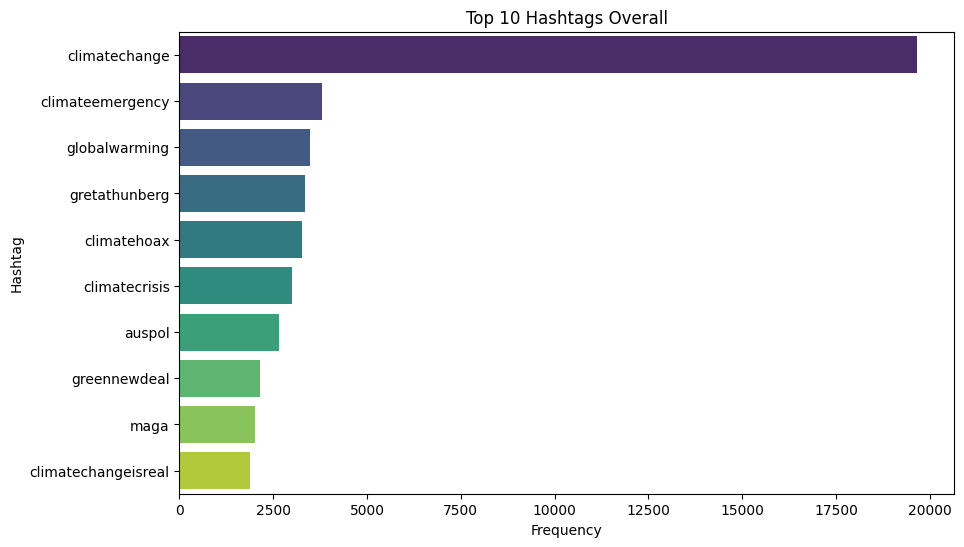

In [ ]:
# Visualization of top 10 hashtags
plt.figure(figsize=(10, 6))
sns.barplot(data=hashtag_df.head(10), x='count', y='hashtag', palette='viridis')
plt.title('Top 10 Hashtags Overall')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.show()

**Findings**: The prominence of #climatechange demonstrates its centrality in the discourse, while the diversity of hashtags illustrates varying perspectives, ranging from urgency (#climateemergency) to skepticism (#climatehoax). This aligns with the broader polarization in climate change debates.

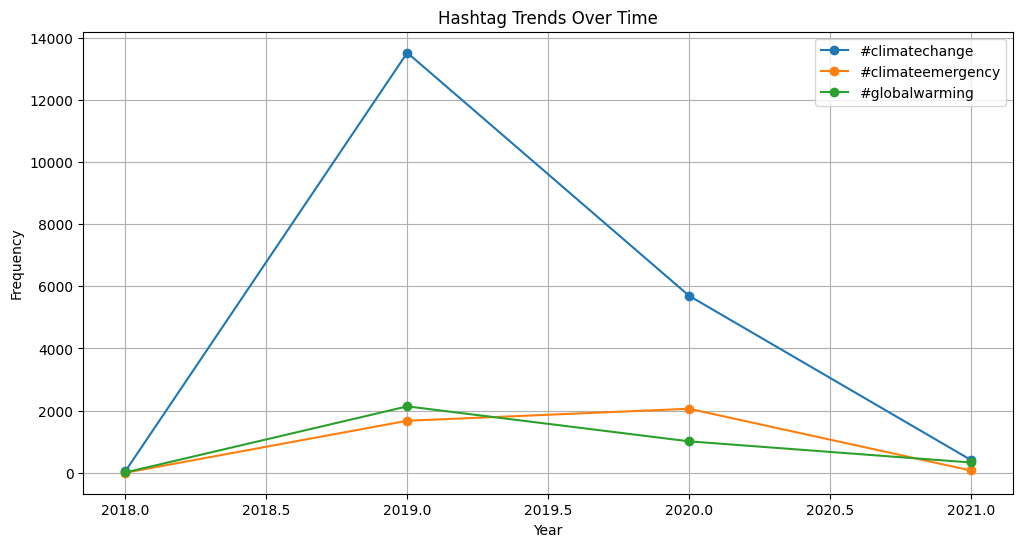

In [ ]:
# Group by year
grouped_by_year = df.groupby('year')

# Count hashtags by year
hashtags_by_year = {}
for year, group in grouped_by_year:
    year_hashtags = [hashtag for hashtags in group['filtered_hashtags'] for hashtag in hashtags]
    hashtags_by_year[year] = Counter(year_hashtags)

# Convert to a DataFrame for visualization
selected_hashtags = ['climatechange', 'climateemergency', 'globalwarming'] # Top 3
trends_data = {year: {ht: counts.get(ht, 0) for ht in selected_hashtags} for year, counts in hashtags_by_year.items()}
trends_df = pd.DataFrame(trends_data).T.fillna(0)

# Import matplotlib if not already imported
import matplotlib.pyplot as plt

# Visualize trends
plt.figure(figsize=(12, 6))
for hashtag in selected_hashtags:
    plt.plot(trends_df.index, trends_df[hashtag], marker='o', label=f'#{hashtag}')
plt.title('Hashtag Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

**Findings**: The hashtag #climatechange saw a significant increase in 2019, likely due to global awareness and events such as climate protests, media coverage, or policy discussions. We will explore this further in Part 4. Meanwhile, #climateemergency and #globalwarming followed steadier trends, suggesting a more consistent but lower level of engagement.

## 1.2 Tweet Lengths Analysis

In [ ]:
# Calculate the length of each tweet
df['tweet_length'] = df['text'].apply(len)
# Inspect
print(df[['text', 'tweet_length']].head())

                                                text  tweet_length
0  Chemtrails Are Part of a (Communist) Agenda 21...           121
1  Trump Says No to Crippling Climate Policy <U+0...           162
2  @marissanovetsky @Evenings_Star @cathmckenna @...           340
3  Investigate this <U+0001F447>\r\n#climatechang...           186
4  Investigate this <U+0001F447>\r\n#climatechang...           186


In [ ]:
# Calculate statistics for tweet length
mean_length = np.mean(df['tweet_length'])
median_length = np.median(df['tweet_length'])
mode_length = stats.mode(df['tweet_length'], keepdims=True)[0][0]  # Extract the mode value

# Print the results
print(f"Mean tweet length: {mean_length:.2f}")
print(f"Median tweet length: {median_length}")
print(f"Mode tweet length: {mode_length}")

Mean tweet length: 234.97
Median tweet length: 244.0
Mode tweet length: 254


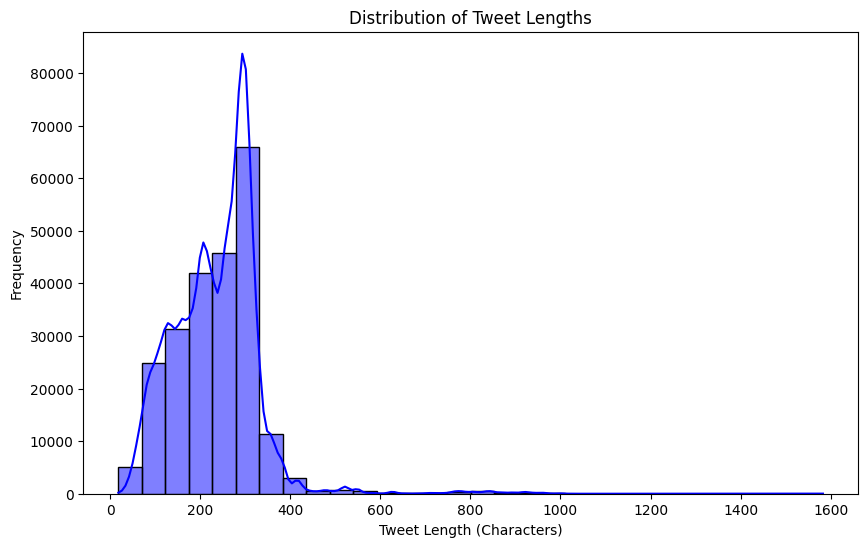

In [ ]:
# Distribution of Tweet Lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Frequency')
plt.show()

### Analyze Popularity by Tweet Length

In [ ]:
# Convert to numeric (favorite_count, retweet_count)
df['favorite_count'] = pd.to_numeric(df['favorite_count'], errors='coerce')
df['retweet_count'] = pd.to_numeric(df['retweet_count'], errors='coerce')

Group tweets by length and calculate the average likes and retweets to see if there’s a correlation.

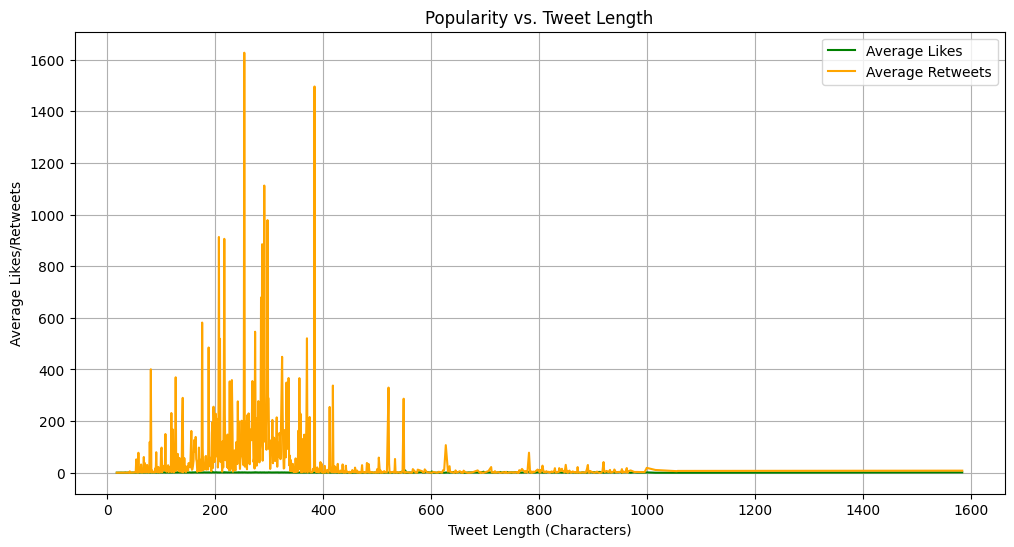

In [ ]:
# Popularity(by length)
length_popularity = df.groupby('tweet_length')[['favorite_count', 'retweet_count']].mean()

# Reset index for easier plotting
length_popularity = length_popularity.reset_index()

# Visualize average likes and retweets vs. tweet length
plt.figure(figsize=(12, 6))
sns.lineplot(data=length_popularity, x='tweet_length', y='favorite_count', label='Average Likes', color='green')
sns.lineplot(data=length_popularity, x='tweet_length', y='retweet_count', label='Average Retweets', color='orange')
plt.title('Popularity vs. Tweet Length')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Average Likes/Retweets')
plt.legend()
plt.grid(True)
plt.show()

Compare Short and Long Tweets: Define "short" and "long" tweets (e.g., based on median length) and compare their average popularity.

In [ ]:
# Define short and long tweets
median_length = df['tweet_length'].median()
df['tweet_category'] = df['tweet_length'].apply(lambda x: 'Short' if x <= median_length else 'Long')

# Calculate average likes and retweets for each category
popularity_by_category = df.groupby('tweet_category')[['favorite_count', 'retweet_count']].mean()

print(popularity_by_category)

                favorite_count  retweet_count
tweet_category                               
Long                  1.046495     275.264356
Short                 1.071230     136.639793


Visualize Short vs. Long Tweet Popularity: compare the average likes and retweets of short and long tweets

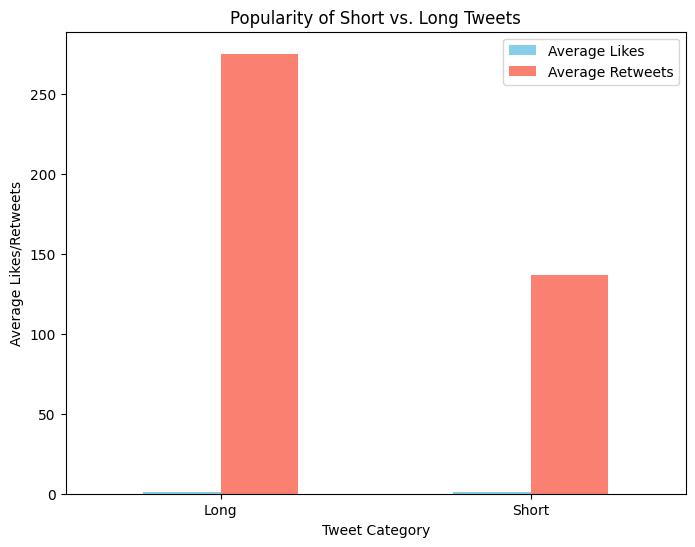

In [ ]:
# Visualize short vs. long tweet popularity
popularity_by_category.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'salmon'])
plt.title('Popularity of Short vs. Long Tweets')
plt.ylabel('Average Likes/Retweets')
plt.xlabel('Tweet Category')
plt.xticks(rotation=0)
plt.legend(['Average Likes', 'Average Retweets'])
plt.show()

**Findings**: The skewness reflects that users tend to maximize tweet space, especially when addressing complex or controversial topics like climate change. The high median length suggests that users are concise but thorough in their messaging. Long Tweets tend to engage audiences more through likes, indicating that more detailed content resonates with users who approve the message. Short Tweets are more likely to be retweeted , possibly due to their concise nature and ease of sharing.

## 1.3 TF-IDF Analysis

We can know which words or phrases are most prominent in the tweets.

In [ ]:
# Removing Round: 3
terms_to_remove = ['climate', 'change', 'hoax', 'global', 'warming', 'fraud', "year", "like", "people", "know", "think", "say", "want",
    "go", "tell", "child", "thank", 'world']

# Regex pattern
pattern = r'\b(?:' + '|'.join(map(re.escape, terms_to_remove)) + r')\b'

# Remove
df['removed_text'] = df['cleaned_text'].str.replace(pattern, '', regex=True).str.strip()

# Inspect Dataframe
display(df[['text', 'cleaned_text', 'removed_text']].head(10))

text  \
0  Chemtrails Are Part of a (Communist) Agenda 21...   
1  Trump Says No to Crippling Climate Policy <U+0...   
2  @marissanovetsky @Evenings_Star @cathmckenna @...   
3  Investigate this <U+0001F447>\r\n#climatechang...   
4  Investigate this <U+0001F447>\r\n#climatechang...   
5  "How much longer can the Left say ""it's our l...   
6  "How much longer can the Left say ""it's our l...   
7  Brave #Resistance hero too stupid to realize @...   
8  Hey, #Resistance hero. I want to be a #Resista...   
9  <U+0001F602><U+0001F602><U+0001F602> LMAO fav/...   

                                        cleaned_text  \
0        chemtrail communist agenda willem felderhof   
1                 trump say crippling climate policy   
2  o american scientist sign petition deny man cl...   
3  investigate see reason fraud call climate chan...   
4  investigate see reason fraud call climate chan...   
5                        long left chance save earth   
6                        long left chance save earth   
7         brave hero stupid realize republican party   
8  hey hero want hero especially tweet like hundr...   
9  lmao fav rt venus ideal living condition despi...   

                                        removed_text  
0        chemtrail communist agenda willem felderhof  
1                           trump  crippling  policy  
2  o american scientist sign petition deny man   ...  
3          investigate see reason  call   conspiracy  
4          investigate see reason  call   conspiracy  
5                        long left chance save earth  
6                        long left chance save earth  
7         brave hero stupid realize republican party  
8  hey hero  hero especially tweet  hundred beat ...  
9  lmao fav rt venus ideal living condition despi...

In [ ]:
# TF-IDF scores & matrix & feature names
def calculate_tfidf_scores(text_column):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text_column)
    feature_names = vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

# Ensure cleaned_text and removed_text columns are strings
df['cleaned_text'] = df['cleaned_text'].astype(str)
df['removed_text'] = df['removed_text'].astype(str)

# Calculate TF-IDF for both columns
tfidf_matrix_cleaned, feature_names_cleaned = calculate_tfidf_scores(df['cleaned_text'])
tfidf_matrix_removed, feature_names_removed = calculate_tfidf_scores(df['removed_text'])

In [ ]:
# Extracting scores for removed_text
removed_scores = tfidf_matrix_removed.sum(axis=0).A1
tfidf_df_removed = pd.DataFrame({'term': feature_names_removed, 'score': removed_scores})

# Sorting
tfidf_df_removed_sorted = tfidf_df_removed.sort_values(by='score', ascending=False)

# Top 20 terms
tfidf_df_removed_top20 = tfidf_df_removed_sorted.head(20)
print(tfidf_df_removed_top20)

            term        score
8907       greta  2421.882027
1796     believe  2388.857227
206     activist  2358.886053
18039  scientist  2305.075211
3079       cause  2208.268334
16484       push  2160.174727
21327         un  2096.150780
11363        kid  1930.423910
13858       need  1818.783475
20669       time  1817.210700
13408      money  1809.307777
7581        fire  1807.250255
4251     control  1797.187464
16776       real  1781.700511
13943        new  1774.579703
19590       stop  1771.961076
18026    science  1769.118511
11938        lie  1755.927344
12521        man  1739.908777
6217       earth  1674.257587


### Visualize the Top Terms

<ipython-input-21-830d3664a6ef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tfidf_df_removed_top20, x='score', y='term', palette='viridis')


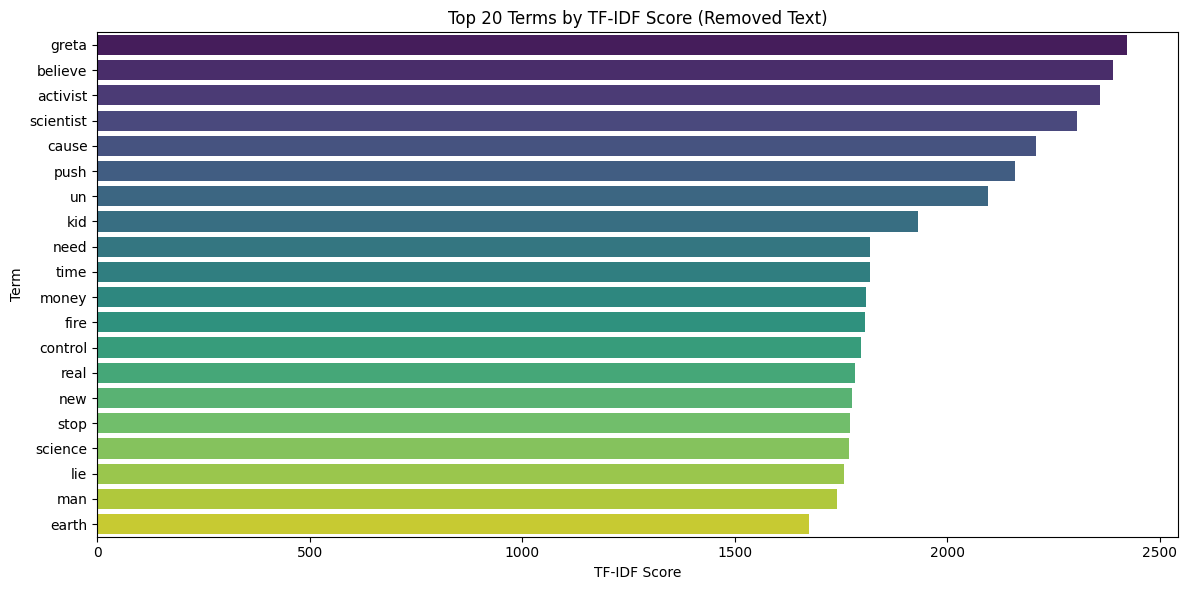

In [ ]:
# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=tfidf_df_removed_top20, x='score', y='term', palette='viridis')
plt.title('Top 20 Terms by TF-IDF Score (Removed Text)')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.tight_layout()
plt.show()

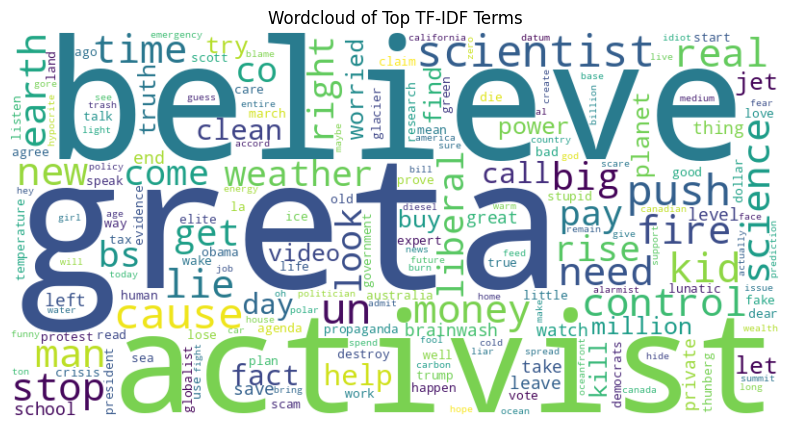

In [ ]:
# Wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(zip(tfidf_df_removed['term'], tfidf_df_removed['score']))
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Top TF-IDF Terms')
plt.show()

### TF-IDF Analysis by year

In [ ]:
# Group by year and calculate TF-IDF for each year
yearly_tfidf = {}
for year, group in df.groupby('year'):
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix_year = vectorizer.fit_transform(group['removed_text'])
    tfidf_feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix_year.sum(axis=0).A1
    yearly_tfidf[year] = pd.DataFrame({'term': tfidf_feature_names, 'score': tfidf_scores}).sort_values(by='score', ascending=False)

# Top 5 terms for each years
print(f"Top Terms for 2018:\n{yearly_tfidf[2018].head(5)}")
print(f"Top Terms for 2019:\n{yearly_tfidf[2019].head(5)}")
print(f"Top Terms for 2020:\n{yearly_tfidf[2020].head(5)}")
print(f"Top Terms for 2021:\n{yearly_tfidf[2021].head(5)}")

Top Terms for 2018:
      term      score
82    talk  14.652946
46     man  13.565885
60  policy  13.519059
42     let  13.227972
87   truth  12.635338
Top Terms for 2019:
         term        score
33      greta  4760.735856
72       push  4279.663073
4     believe  4261.953909
81  scientist  4060.092677
0    activist  3552.969781
Top Terms for 2020:
       term        score
68      pay  1959.366960
20     come  1764.506621
80  science  1761.498514
16    cause  1756.245906
28    earth  1632.866359
Top Terms for 2021:
        term       score
81   science  257.778467
91      time  215.794674
78     right  207.928962
74   quickly  185.163246
12  congress  183.401234


In [ ]:
# Collect top terms and scores for all years
top_terms_by_year = []

for year, group in df.groupby('year'):
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(group['removed_text'])
    tfidf_feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    top_terms = pd.DataFrame({
        'year': year,
        'term': tfidf_feature_names,
        'score': tfidf_scores
    }).sort_values(by='score', ascending=False).head(10)  # Top 10 terms

    top_terms_by_year.append(top_terms)

# Combine into DataFrame
top_terms_by_year_df = pd.concat(top_terms_by_year, ignore_index=True)

# Inspect
print(top_terms_by_year_df.head())

   year    term      score
0  2018    talk  14.652946
1  2018     man  13.565885
2  2018  policy  13.519059
3  2018     let  13.227972
4  2018   truth  12.635338


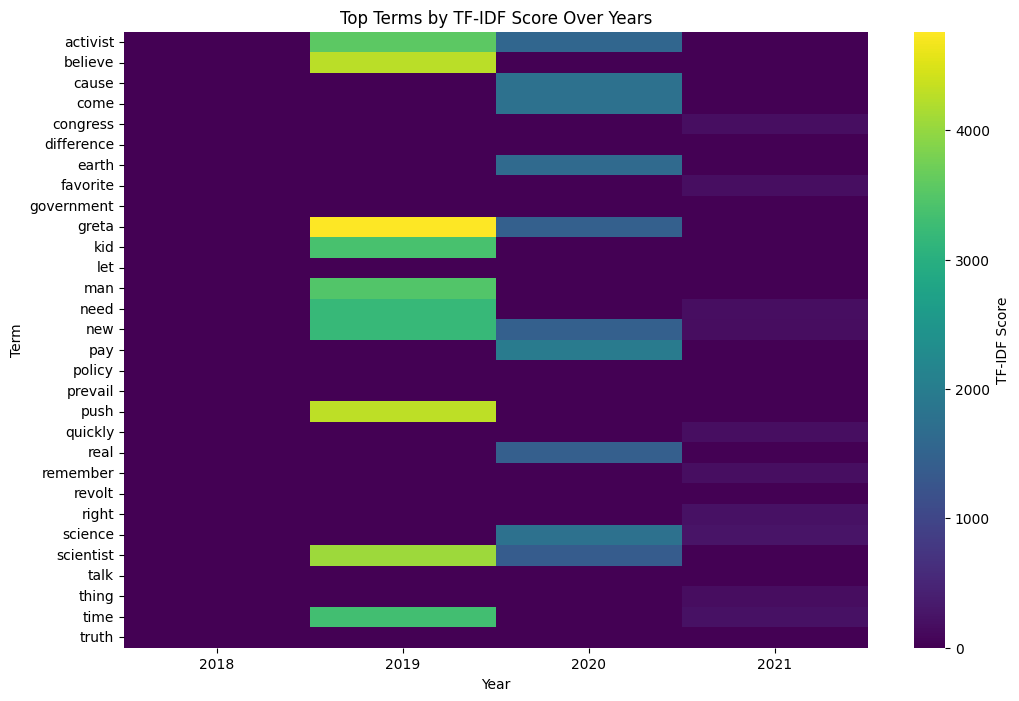

In [ ]:
heatmap_data = top_terms_by_year_df.pivot(index='term', columns='year', values='score').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, cbar_kws={'label': 'TF-IDF Score'})
plt.title('Top Terms by TF-IDF Score Over Years')
plt.xlabel('Year')
plt.ylabel('Term')
plt.show()

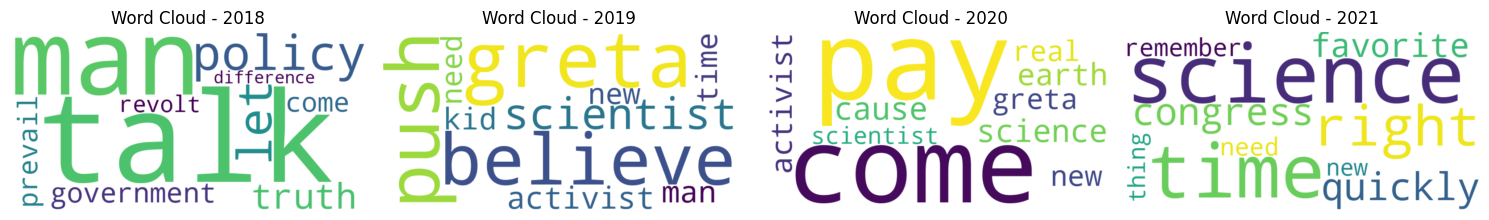

In [ ]:
# Group terms and scores by year
years = sorted(top_terms_by_year_df['year'].unique())
wordcloud_data = {
    year: {
        row['term']: row['score']
        for _, row in top_terms_by_year_df[top_terms_by_year_df['year'] == year].iterrows()
    }
    for year in years
}

# Create word clouds and visualize side-by-side
fig, axes = plt.subplots(1, len(years), figsize=(15, 6))

for i, year in enumerate(years):
    wc = WordCloud(width=800, height=400, background_color="white", colormap="viridis")
    wc.generate_from_frequencies(wordcloud_data[year])

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(f"Word Cloud - {year}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

**Findings**: The climate conversation evolved from general discussions (2018) to activism-led debates (2019), followed by a focus on financial and scientific aspects (2020), and finally, a more policy-oriented discourse (2021). This trend aligns with major global events, including climate strikes, policy initiatives, and shifting public concerns over time.

##  1.4 k-Means

Identifying overarching themes and narratives.

 ### 1.4.1 Top terms per theme

Optimal number of clusters for cleaned_text: 9
Optimal number of clusters for removed_text: 9


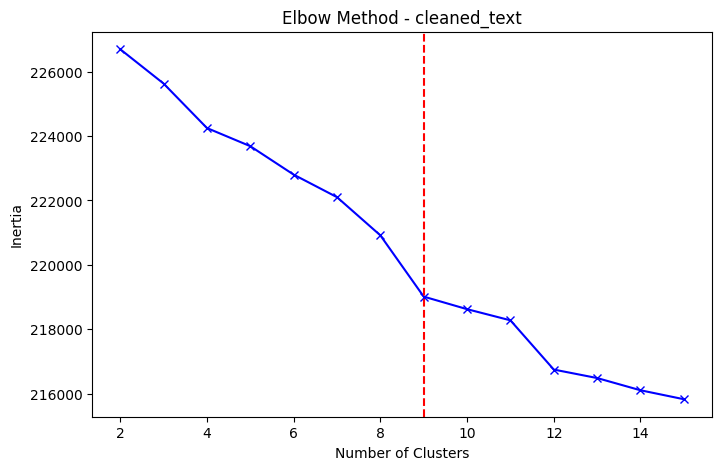

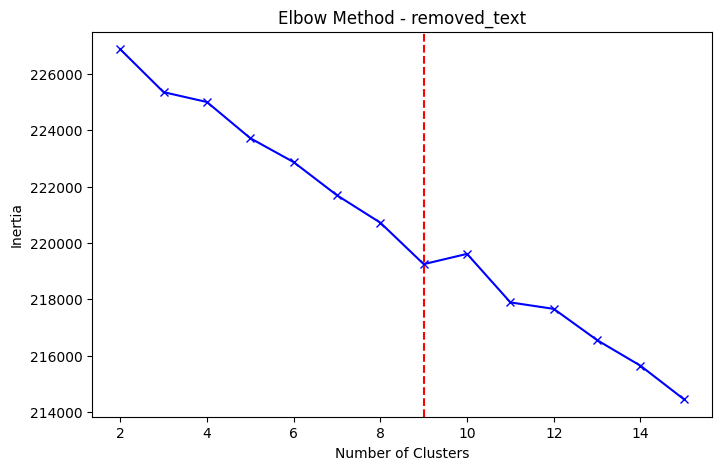

In [ ]:
# Elbow method to determine optimal number of clusters
def determine_optimal_clusters(tfidf_matrix, max_clusters=15):
    inertia = []
    K = range(2, max_clusters + 1)

    # Run K-Means for different values of K
    for k in K:
        kmeans = KMeans(n_clusters=k,
                        init='k-means++',
                        random_state=42,  # For reproducibility
                        n_init=10,  # Run the clustering 10 times
                        max_iter=100)  # Iterate 100 times

        kmeans.fit(tfidf_matrix)
        inertia.append(kmeans.inertia_)

    # Determine optimal k using the knee point
    kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
    optimal_k = kn.knee
    return optimal_k, inertia, K

# Determine optimal number of clusters for cleaned_text and removed_text
optimal_k_cleaned, inertia_cleaned, K_cleaned = determine_optimal_clusters(tfidf_matrix_cleaned)
optimal_k_removed, inertia_removed, K_removed = determine_optimal_clusters(tfidf_matrix_removed)

# Print optimal k values for both
print(f"Optimal number of clusters for cleaned_text: {optimal_k_cleaned}")
print(f"Optimal number of clusters for removed_text: {optimal_k_removed}")

# Plot elbow graph for cleaned_text
plt.figure(figsize=(8, 5))
plt.plot(K_cleaned, inertia_cleaned, 'bx-')
plt.axvline(x=optimal_k_cleaned, linestyle='--', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - cleaned_text')
plt.show()

# Plot elbow graph for removed_text
plt.figure(figsize=(8, 5))
plt.plot(K_removed, inertia_removed, 'bx-')
plt.axvline(x=optimal_k_removed, linestyle='--', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - removed_text')
plt.show()

We get the output as:
Optimal number of clusters for cleaned_text: 10
Optimal number of clusters for removed_text: 9

In [ ]:
# K-Means clustering
kmeans_cleaned = KMeans(n_clusters=10, random_state=42)
kmeans_removed = KMeans(n_clusters=9, random_state=42)

# Fit K-Means model
kmeans_cleaned.fit(tfidf_matrix_cleaned)
kmeans_removed.fit(tfidf_matrix_removed)

# Assign clusters to each document
df['cluster_cleaned'] = kmeans_cleaned.labels_
df['cluster_removed'] = kmeans_removed.labels_

In [ ]:
# Extract top keywords from each cluster
def get_top_keywords(kmeans_model, feature_names, top_n=10):
    top_keywords = {}
    for i in range(kmeans_model.n_clusters):
        cluster_center = kmeans_model.cluster_centers_[i]
        top_indices = cluster_center.argsort()[-top_n:][::-1]
        top_keywords[i] = [feature_names[idx] for idx in top_indices]

    return top_keywords

top_keywords_cleaned = get_top_keywords(kmeans_cleaned, feature_names_cleaned, top_n=10)
top_keywords_removed = get_top_keywords(kmeans_removed, feature_names_removed, top_n=10)

In [ ]:
print("Top terms per cluster for cleaned text:")
print("-" * 40)
for i in range(kmeans_cleaned.n_clusters):
    print(f"\nCluster {i + 1}:")
    terms = ", ".join(top_keywords_cleaned[i])
    print(f"Top terms: {terms}")

print("\n" + "=" * 50 + "\n")  # Separator between cleaned and removed results

print("Top terms per cluster for removed text:")
print("-" * 40)
for i in range(kmeans_removed.n_clusters):
    print(f"\nCluster {i + 1}:")
    terms = ", ".join(top_keywords_removed[i])
    print(f"Top terms: {terms}")

Top terms per cluster for cleaned text:
----------------------------------------

Cluster 1:
Top terms: sea, level, rise, glacier, land, cause, entire, becuase, northern, float

Cluster 2:
Top terms: year, climate, like, global, think, world, warming, go, want, child

Cluster 3:
Top terms: pay, earth, spread, figure, preach, powerful, virus, taxis, temperature, government

Cluster 4:
Top terms: stelter, stop, channel, founder, brian, fiction, cnn, weather, listen, talk

Cluster 5:
Top terms: climate, change, hoax, activist, scientist, worried, clean, march, push, scott

Cluster 6:
Top terms: know, liar, well, work, cause, try, deception, lie, datum, fraud

Cluster 7:
Top terms: kid, endorse, youtube, fully, dear, speak, die, take, get, un

Cluster 8:
Top terms: save, planet, world, green, say, prez, sanction, society, enter, rip

Cluster 9:
Top terms: people, climate, change, bring, believe, come, long, like, car, queen

Cluster 10:
Top terms: video, dan, camp, helicopter, google, clim

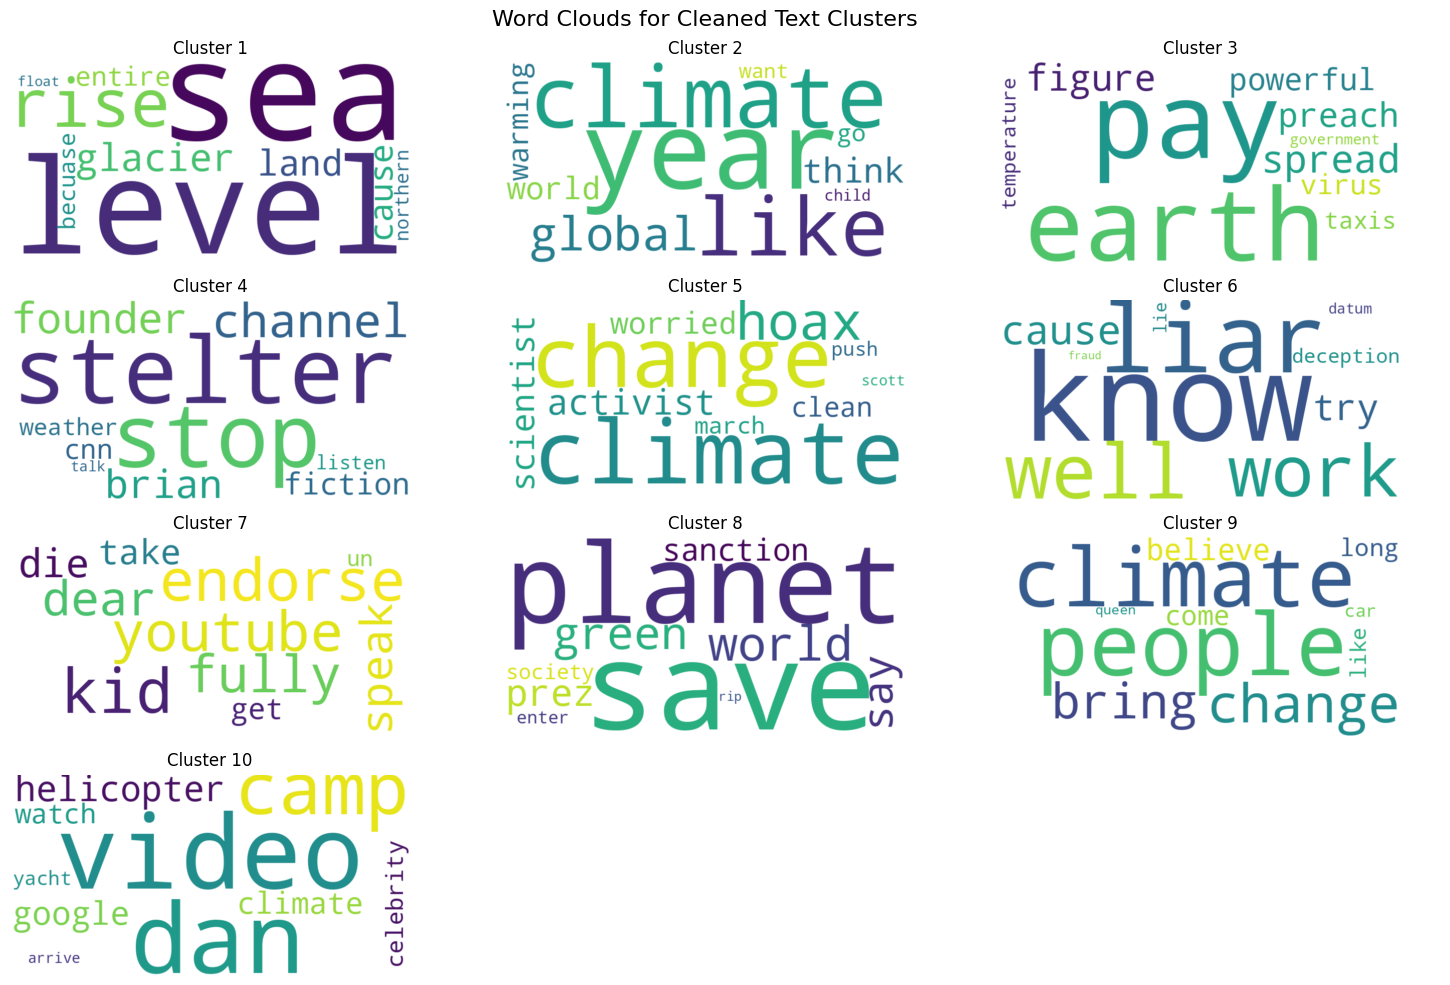

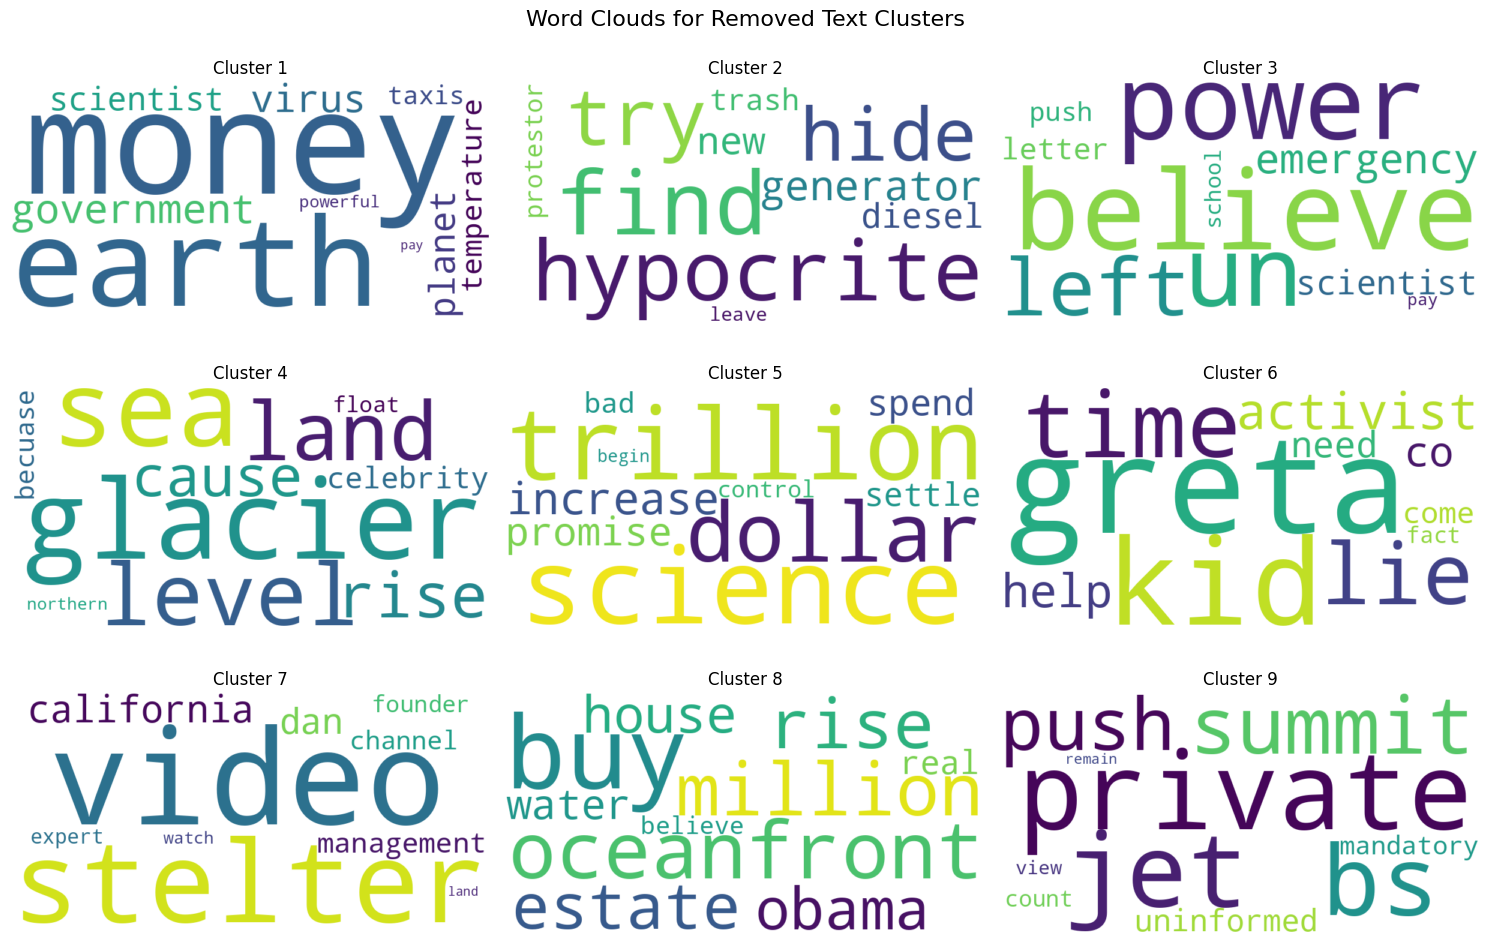

In [ ]:
# Convert top keywords to frequency dictionaries for both cleaned and removed text
def create_frequency_dict(keywords_dict):
    cluster_terms = []
    # Since we're using top keywords, we'll create artificial frequencies
    # decreasing by position to show relative importance
    for cluster in keywords_dict.values():
        freq_dict = {}
        for i, word in enumerate(cluster):
            # Create descending frequencies (10 for first word, 9 for second, etc.)
            freq_dict[word] = 10 - i
        cluster_terms.append(freq_dict)
    return cluster_terms

# Create frequency dictionaries
cleaned_cluster_terms = create_frequency_dict(top_keywords_cleaned)
removed_cluster_terms = create_frequency_dict(top_keywords_removed)

# Create word clouds for cleaned text
fig1, axes1 = plt.subplots(ncols=3,
                          nrows=math.ceil(len(cleaned_cluster_terms) / 3),
                          figsize=(15, 10))
fig1.suptitle("Word Clouds for Cleaned Text Clusters", fontsize=16)

for i, (cluster, ax) in enumerate(zip(cleaned_cluster_terms, axes1.flatten())):
    wordcloud = WordCloud(background_color='white',
                         width=800,
                         height=400,
                         max_words=10,
                         relative_scaling=0.5)
    wordcloud.generate_from_frequencies(cluster)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Cluster {i+1}", fontsize=12)
    ax.axis('off')

# Turn off any remaining empty axes
for ax in axes1.flatten()[len(cleaned_cluster_terms):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Create word clouds for removed text
fig2, axes2 = plt.subplots(ncols=3,
                          nrows=math.ceil(len(removed_cluster_terms) / 3),
                          figsize=(15, 10))
fig2.suptitle("Word Clouds for Removed Text Clusters", fontsize=16)

for i, (cluster, ax) in enumerate(zip(removed_cluster_terms, axes2.flatten())):
    wordcloud = WordCloud(background_color='white',
                         width=800,
                         height=400,
                         max_words=10,
                         relative_scaling=0.5)
    wordcloud.generate_from_frequencies(cluster)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Cluster {i+1}", fontsize=12)
    ax.axis('off')

# Turn off any remaining empty axes
for ax in axes2.flatten()[len(removed_cluster_terms):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

**Findings**: The two versions of K-means clustering reveal distinct thematic groupings in climate-related discourse. Overall, the results indicate that climate discourse is shaped by a mix of scientific facts, activism, political influence, economic considerations, and skepticism

### 1.4.2 Major narratives per year

In [ ]:
# Cluster for each year
yearly_clusters = {}

for year, group in df.groupby('year'):
    # Calculate TF-IDF for the current year's group only
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(group['removed_text']) #Recalculate TF-IDF for the group

    # Apply k-Means clustering
    kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix) #Use the correct TF-IDF matrix

    # Add cluster labels to the DataFrame
    group['cluster'] = cluster_labels
    yearly_clusters[year] = group

# Combine all years back into a single DataFrame
clustered_df = pd.concat(yearly_clusters.values(), ignore_index=True)

# Inspect
print(clustered_df[['year', 'removed_text', 'cluster']].head())

   year                                       removed_text  cluster
0  2018        chemtrail communist agenda willem felderhof        4
1  2018                           trump  crippling  policy        4
2  2018  o american scientist sign petition deny man   ...        4
3  2018          investigate see reason  call   conspiracy        4
4  2018          investigate see reason  call   conspiracy        4


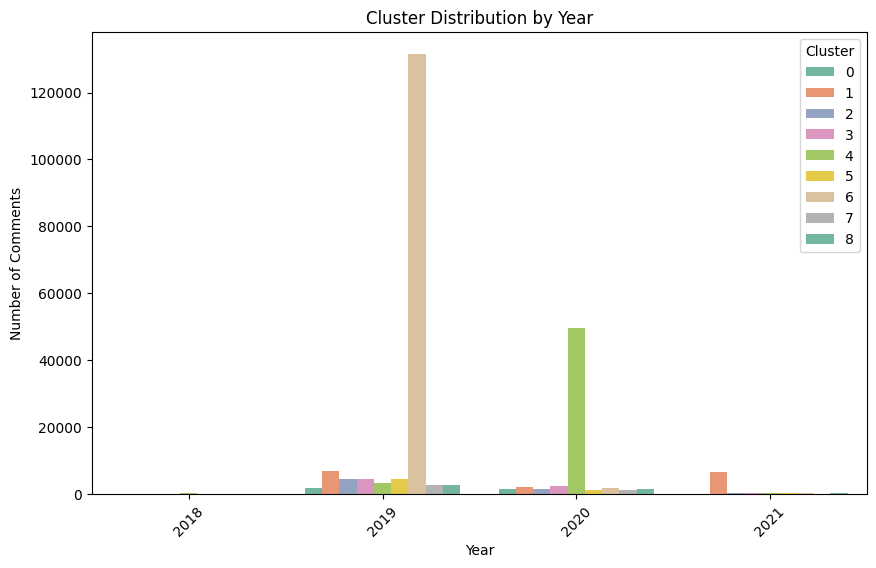

In [ ]:
# Plot the count of clusters per year
plt.figure(figsize=(10, 6))
sns.countplot(data=clustered_df, x='year', hue='cluster', palette='Set2')
plt.title('Cluster Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.legend(title='Cluster', loc='upper right')
plt.xticks(rotation=45)
plt.show()

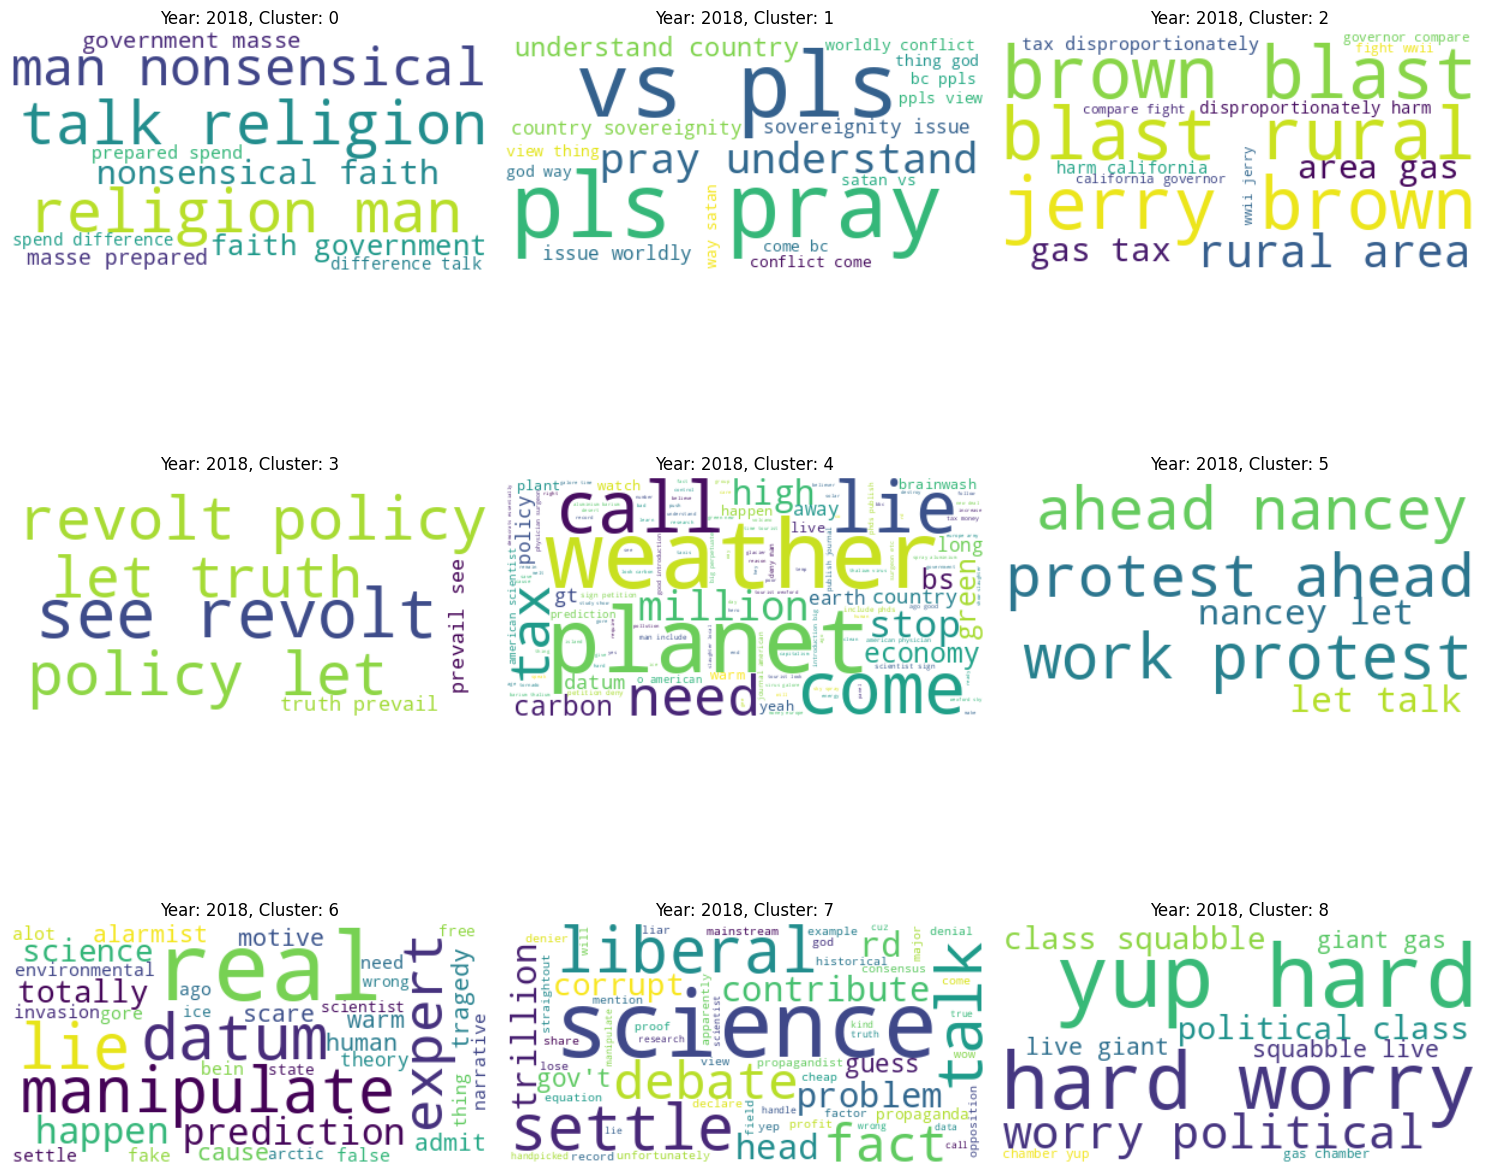

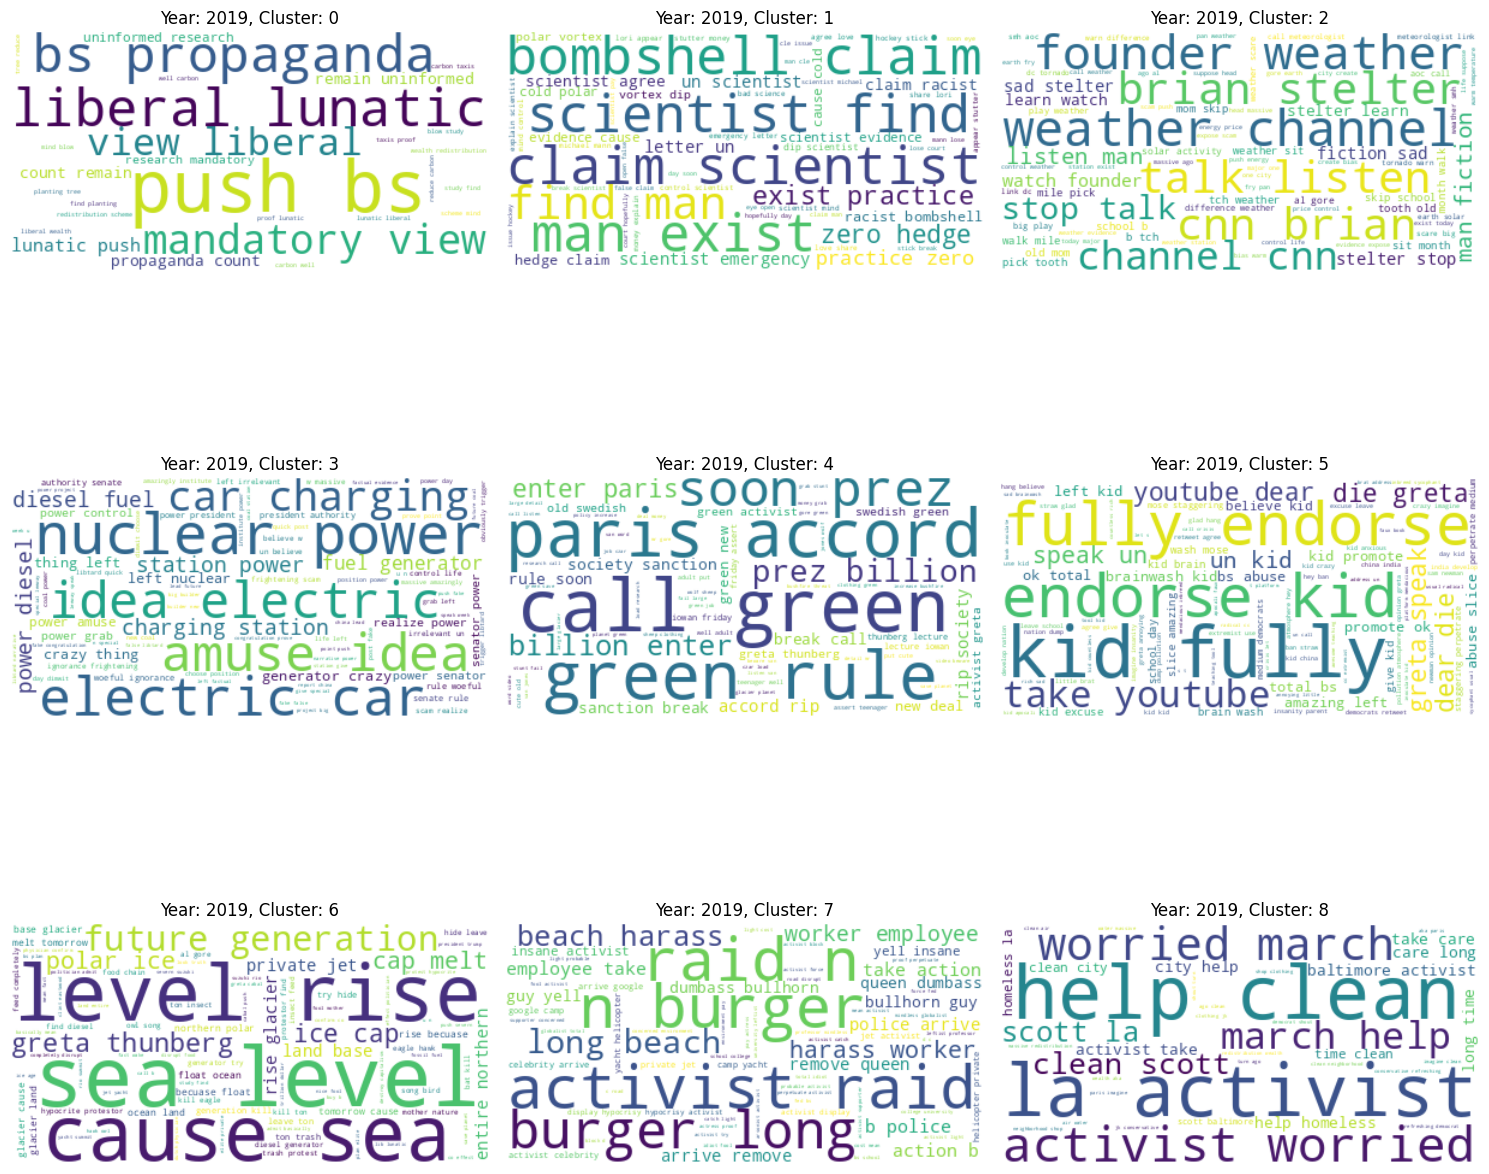

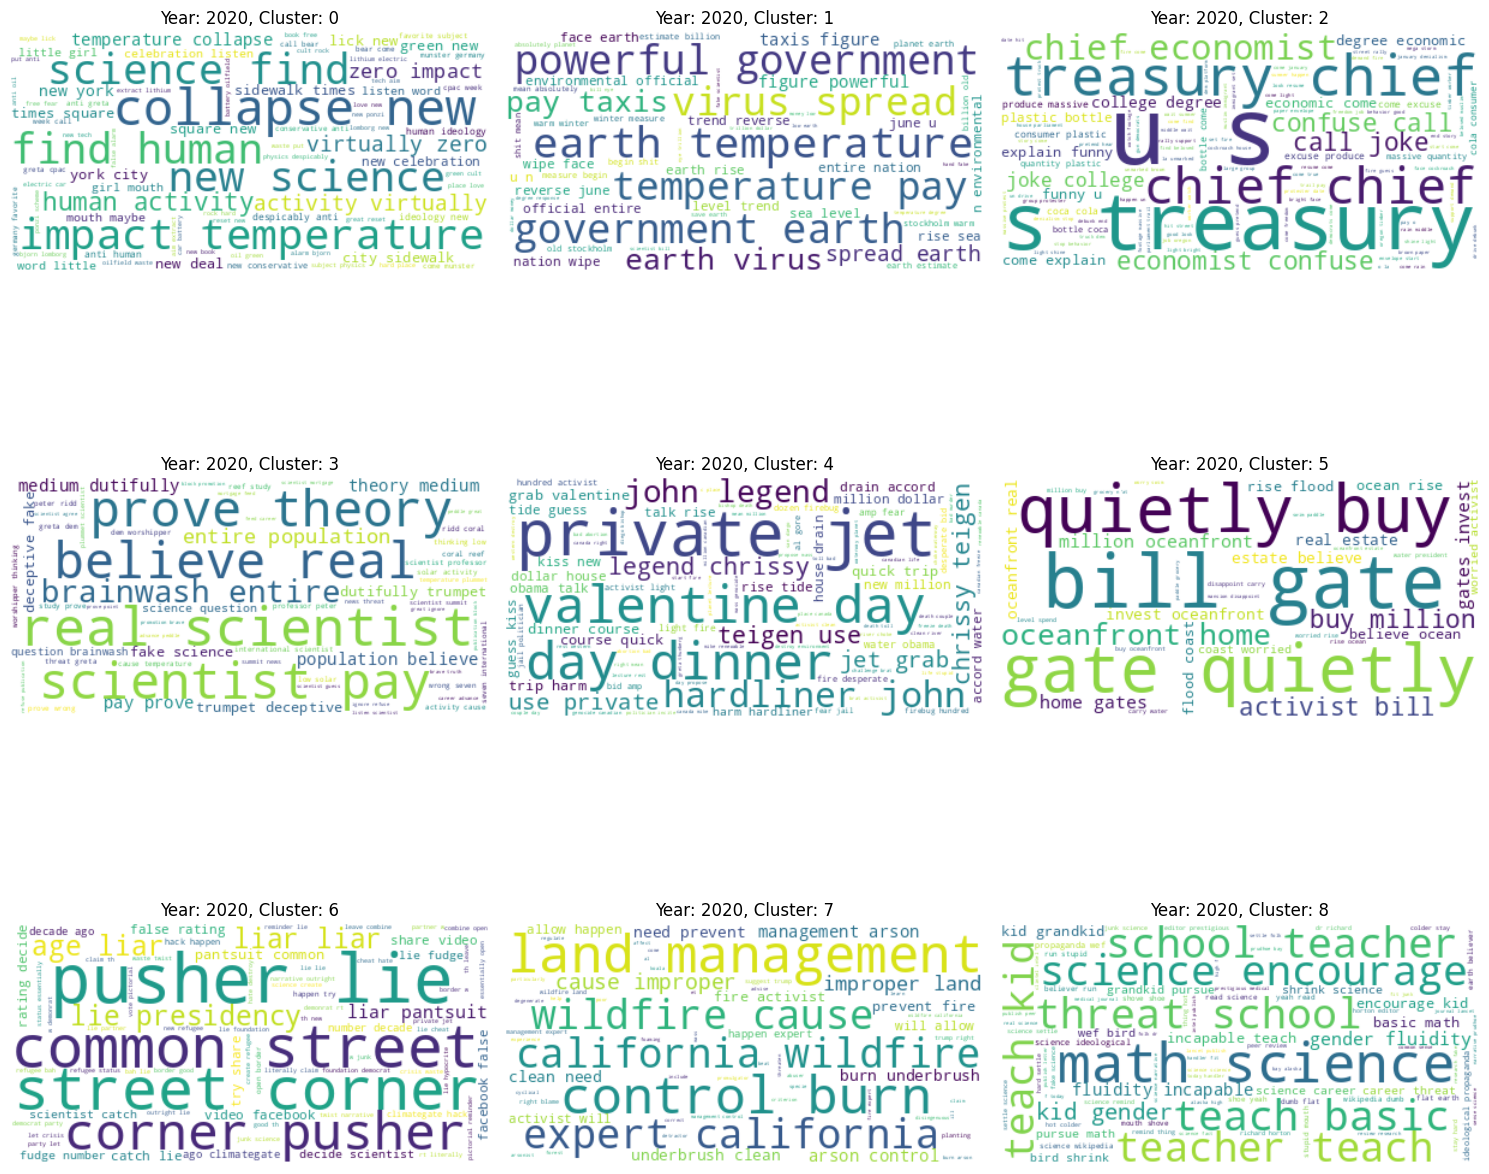

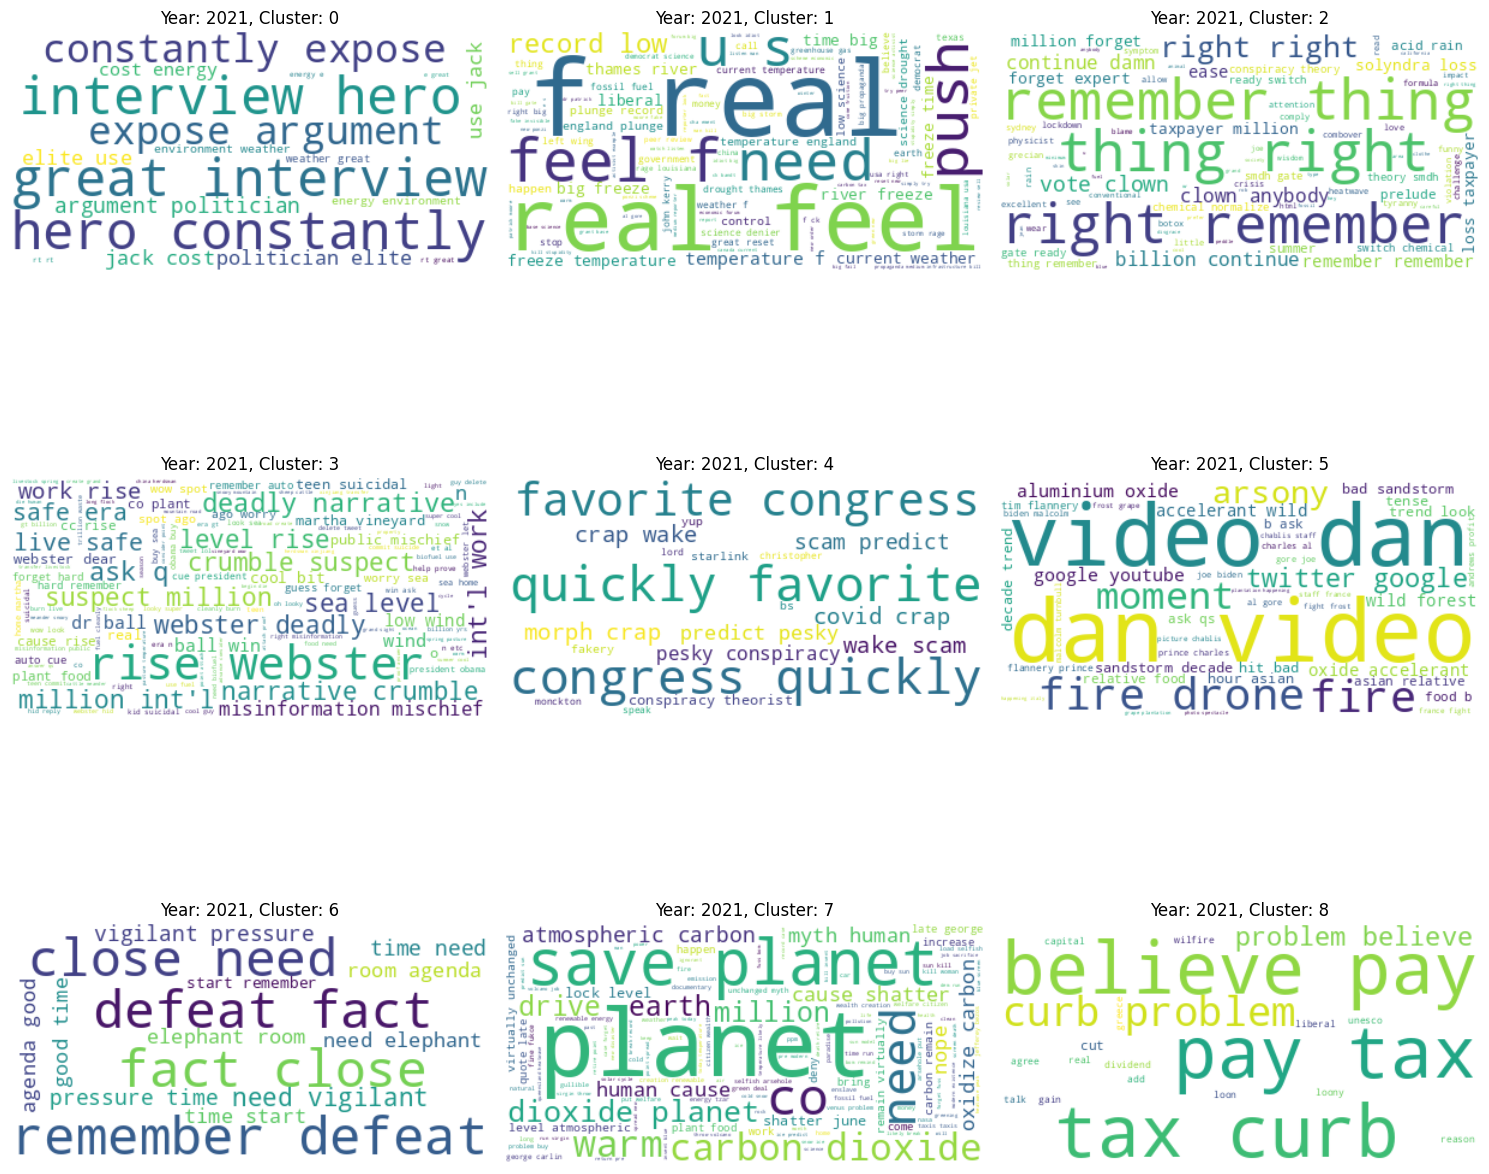

In [ ]:
# Number of word clouds per row
clusters_per_row = 3

for year, group in clustered_df.groupby('year'):
    clusters = sorted(group['cluster'].unique())
    n_clusters = len(clusters)
    n_rows = math.ceil(n_clusters / clusters_per_row)

    fig, axes = plt.subplots(n_rows, clusters_per_row, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, cluster in enumerate(clusters):
        cluster_data = group[group['cluster'] == cluster]['removed_text']
        combined_text = " ".join(cluster_data)

        wordcloud = WordCloud(width=400, height=200, background_color='white').generate(combined_text)

        # Plot the word cloud
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f"Year: {year}, Cluster: {cluster}")
        axes[i].axis('off')

    # Turn off unused subplots
    for j in range(len(clusters), len(axes)):
        axes[j].axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

**Findings**:

2018: Focused on the intersection of religion, economy, and governance, blending moral framing with political and scientific tensions.

2019: Dominated by youth activism, especially Greta Thunberg’s movement, with narratives split between environmental urgency and political resistance.

2020: Shaped by crises like the Australian bushfires, discourse became more confrontational, highlighting tensions between activists and critics.

2021: Evolved into a complex mix of scientific, political, and media-driven narratives, balancing activism with increasing skepticism.

# Task 2

Task 2 focuses on identifying the key figures mentioned in the climate denial conversation on Twitter. By using Named Entity Recognition (NER), we can extract references to individuals, organizations, and other groups mentioned in each tweet. Tracking these entities year by year shows how different voices gain or lose prominence within the climate denial discourse.

##2.1 Extract relevant named entities

Extract relevant named entities from a given text using spaCy.

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  #emoticons
        "\U0001F300-\U0001F5FF"  #symbols & Pictographs
        "\U0001F680-\U0001F6FF"  #transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  #flags
        "\U00002702-\U000027B0"  #dingbats
        "\U000024C2-\U0001F251"  #enclosed characters
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def remove_unicode_sequences(text):
    #pattern to match 'u+' followed by 4 to 6 hexadecimal digits
    unicode_pattern = re.compile(r'u\+[0-9a-fA-F]{4,6}')
    return unicode_pattern.sub('', text)

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def remove_hashtags(text):
    text = re.sub(r'#\w+', '', text)  #remove hashtags
    return text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_non_ascii(text):
    return text.encode('ascii', 'ignore').decode('ascii')

def remove_control_characters(text):
    control_chars = ''.join(['\t', '\n', '\r'])
    control_char_re = re.compile('[%s]' % re.escape(control_chars))
    return control_char_re.sub('', text)

def preprocess_text(text):
    text = remove_actual_emojis(text)
    text = remove_unicode_sequences(text)
    text = remove_urls(text)
    text = remove_mentions_hashtags(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    text = remove_control_characters(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_named_entities(text, nlp):
    #remove emojis before processing
    text = remove_emojis(text)
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "NORP", "GPE"]:
            #clean up extra spaces
            entity_text = re.sub(r"\s+", " ", ent.text.strip())
            entities.append(entity_text)
    return entities

##2.2 Normalize entity references

Normalization that removes @handles, lowercases, and strips common prefixes like 'President', 'Sen.', etc.



In [ ]:
def normalize_entity(entity):
    entity = entity.lower()
    #remove leading @ symbols
    entity = re.sub(r"^@+", "", entity)
    #remove titles/honorifics
    for prefix in ["president ", "sen. ", "senator ", "dr. ", "mr. ", "mrs. ", "ms. ", "prime minister "]:
        entity = entity.replace(prefix, "")
    return entity.strip()

def filter_entities(entities):
    filtered = []
    for entity in entities:
        #exclude entities that are URLs
        if re.match(r'https?://\S+|www\.\S+', entity):
            continue
        #exclude entities with residual Unicode artifacts
        if re.search(r'<u\+[0-9a-fA-F]{4,6}>', entity):
            continue
        #exclude entities with non-alphanumeric characters (except spaces)
        if re.search(r'[^\w\s]', entity):
            continue
        filtered.append(entity)
    return filtered

##2.3 Apply NER + normalization



In [ ]:
df['named_entities'] = df['text'].apply(lambda x: extract_named_entities(x, nlp))
df['named_entities'] = df['named_entities'].apply(lambda ents: [normalize_entity(e) for e in ents if e.strip() != ''])
df['named_entities'] = df['named_entities'].apply(filter_entities)

##2.4 Count entity frequencies

Returns a dictionary where each counter holds entity frequencies for that year.

In [ ]:
def count_entities_by_year(df):
    year_counters = {}
    for year in sorted(df['year'].unique()):
        #get only rows for the current year
        subset = df[df['year'] == year]
        all_entities = []
        for ent_list in subset['named_entities']:
            all_entities.extend(ent_list)
        #count how many times each entity appears in that year
        year_counters[year] = Counter(all_entities)
    return year_counters

entity_counts_by_year = count_entities_by_year(df)

##2.5 Visualize top N entities by year

Createing a barplot showing the top N entities for a given year.

Year 2018 - Top 10 Entities:
[('nwo', 69), ('deepstate', 61), ('creationism', 37), ('understand', 37), ('worldly conflicts', 37), ('blexit', 37), ('religion', 33), ('california', 25), ('policies', 25), ('jerry brown blasts', 24)]


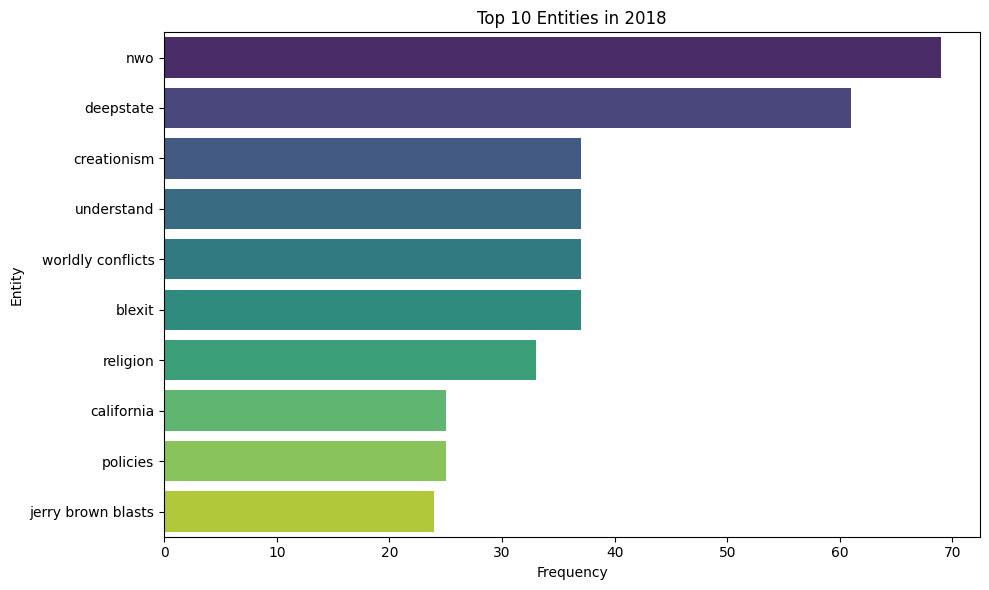

Year 2019 - Top 10 Entities:
[('un', 5369), ('greta', 4820), ('democrats', 3380), ('gretathunberg', 2835), ('climatechange', 2697), ('bs', 2414), ('la', 2358), ('scott', 2346), ('scottpresler', 2278), ('trump', 2079)]


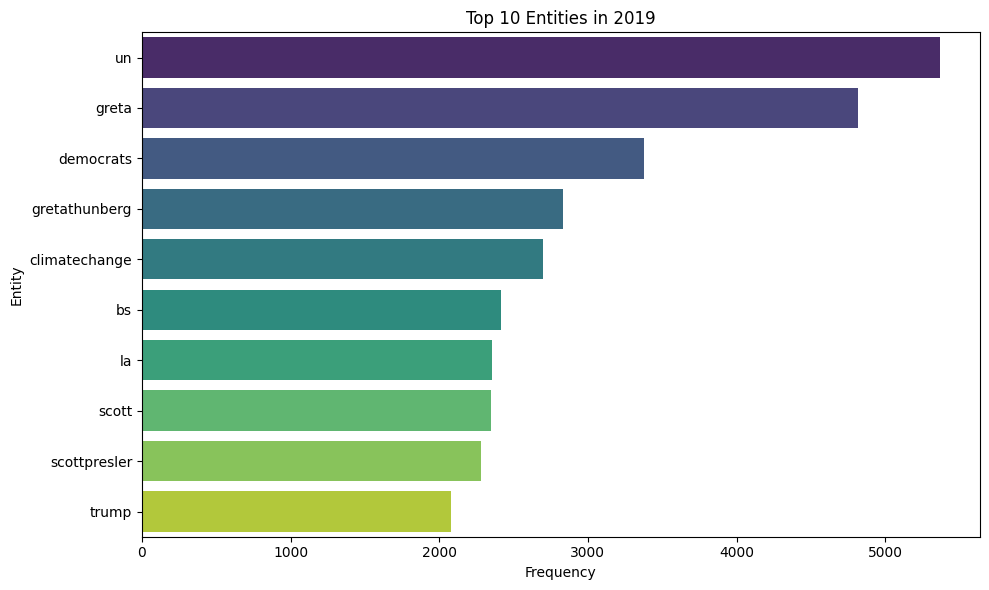

Year 2020 - Top 10 Entities:
[('climatechange', 2242), ('australia', 2072), ('gretathunberg', 1911), ('canada', 1730), ('un', 1448), ('bill gates', 1381), ('obama', 1255), ('democrats', 1234), ('global warming hardliner john legend', 1217), ('saturdaymood', 1217)]


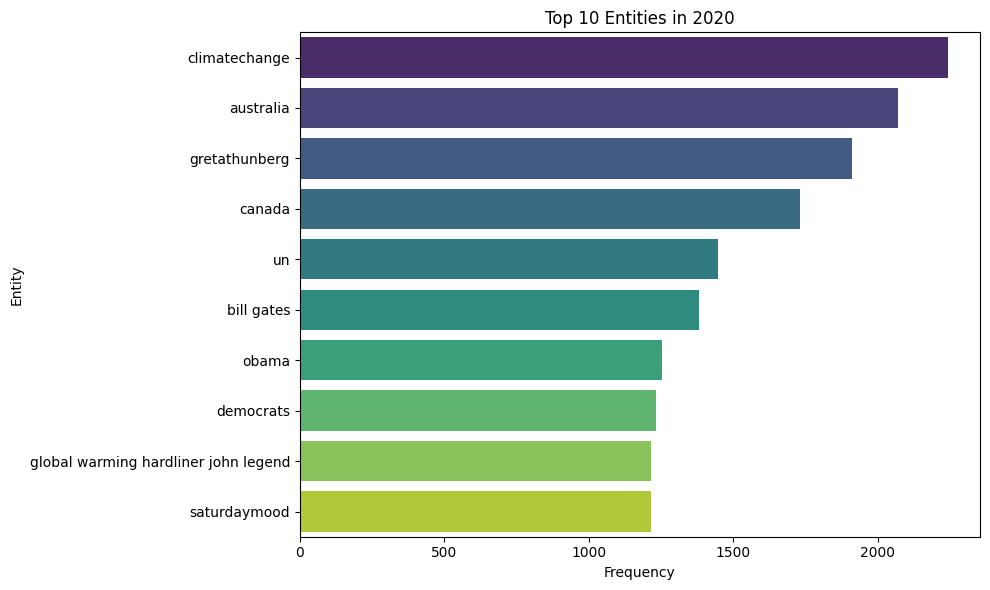

Year 2021 - Top 10 Entities:
[('congress', 314), ('democrats', 291), ('greatreset', 241), ('dan', 171), ('canada', 160), ('china', 137), ('un', 127), ('jwspry', 109), ('twitter', 102), ('texas', 80)]


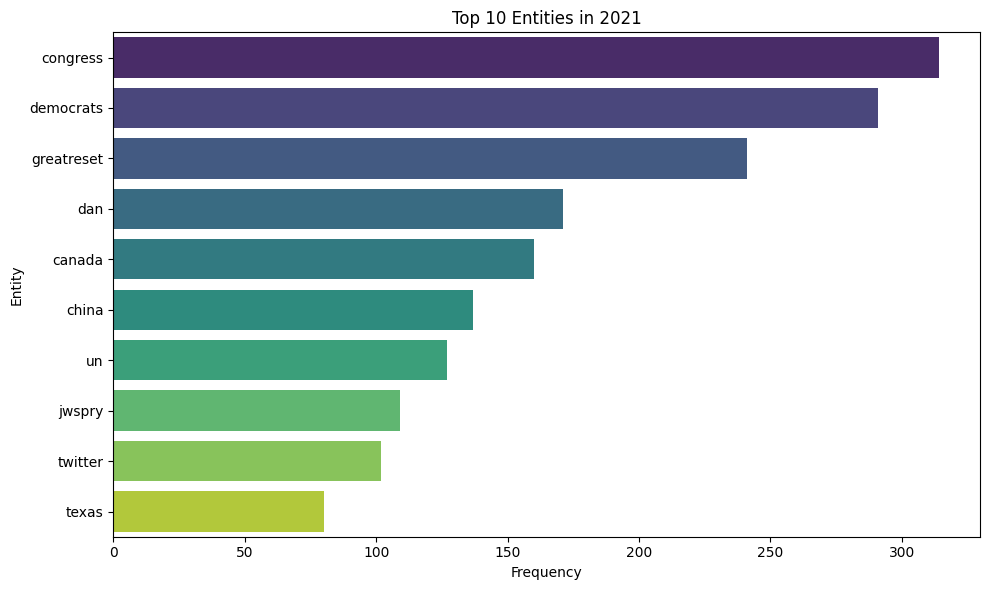

In [ ]:
def count_entities_by_year(df):
    year_counters = {}
    for year in sorted(df['year'].unique()):
        #filter rows for the current year
        subset = df[df['year'] == year]
        all_entities = []
        for ent_list in subset['named_entities']:
            all_entities.extend(ent_list)
        #count occurrences of each entity
        year_counters[year] = Counter(all_entities)
    return year_counters


def plot_top_entities(year_counts, year, top_n=10):
    counter = year_counts.get(year, None)
    if counter is None:
        print(f"No data available for year {year}.")
        return

    top_entities = counter.most_common(top_n)
    if not top_entities:
        print(f"No entities found for year {year}.")
        return

    labels = [x[0] for x in top_entities]
    values = [x[1] for x in top_entities]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=values, y=labels, hue=labels, palette='viridis', dodge=False)
    plt.title(f"Top {top_n} Entities in {year}")
    plt.xlabel("Frequency")
    plt.ylabel("Entity")
    plt.legend([], [], frameon=False)  # Hide the legend
    plt.tight_layout()
    plt.show()

#count entities by year
entity_counts_by_year = count_entities_by_year(df)

#define unique_years outside the function
unique_years = sorted(df['year'].unique())

#plot top 10 entities for each year
for y in unique_years:
    print(f"Year {y} - Top 10 Entities:")
    print(entity_counts_by_year[y].most_common(10))
    plot_top_entities(entity_counts_by_year, y, top_n=10)

# Task 3

Task three investigates the use of different tactics used by climate change deniers to spread their views online. It aims to answer the following research question:

  *What tactics are used to spread ideas within the discourse on climate change denial?*

## 3.1 Defining patterns for each of the tactics and adding them to the dataframe

I manually scanned through 350 randomly selected tweets in the dataset and discovered words that could be used to indicate a tactic used by climate change denyers to spread their ideas. In this section, I define these patterns in the code and check through the dataset to find which tweets match these patterns.

In [ ]:
# Defining the patterns as lists of keywords
patterns = {
    'power_conspiracy': ['enslave', 'internment camp', 'censorship', 'invade', 'ruse', 'slavery', 'colonize', 'tyrannical', 'control', 'propaganda', 'brainwash', 'agenda'],
    'leftist_conspiracy': ['communist', 'liberalism mental disorder', 'liberalism disease', 'leftist', 'leftie', 'lefty', 'liberal', 'marxist', 'communism', 'socialism', 'eat baby'],
    'alternate_science': ['chemtrail', 'real motive', 'truth', 'lie', 'scientific datum', 'petition', 'geo engineering', 'geoengineering', 'weather', 'fact', 'glacier', 'settled science', 'nasa'],
    'climate_denial': ['conspiracy', 'fraud', 'false', 'fake', 'hysteria', 'bullshit', 'man made climate change', 'scheme', 'alarmist', 'dinosaurfart', 'garbage'],
    'prediction_failure': ['wrong', 'prediction', 'manipulate', 'year', 'ice', 'melt', 'extinct' 'polar bear'],
    'money_scam': ['scam', 'tax', 'screw', 'middle class', 'million', 'corrupt', 'carbon tax', 'sham', 'swindle', 'profit', 'carbon credit', 'redistribution', 'waste money', 'taxpayer', 'elite', 'expensive'],
    'secondary_issues': ['windturbine', 'turbine', 'solar panel', 'clean water', 'electric car', 'ocean'],
    'eco_hypocrisy': ['fly', 'jet', 'plane', 'hypocrisy', 'polluter', 'off the grid', 'heat'],
    'blame_others': ['china', 'india', 'brazil', 'other country'],
    'personal_attacks': ['evil', 'freak', 'loon', 'fool', 'twit', 'idiot', 'lunatic', 'moron', 'rat', 'insane', 'normie', 'stupidity', 'moronic', 'phoney', 'shithole', 'nut', 'liar'],
    'climate_doom': ['impossible', 'too late', 'fate']
}

# Function to check if any of the patterns are in a tweet
def check_patterns(text, patterns):
    results = {}
    for pattern, keywords in patterns.items():
        results[pattern] = any(keyword in text for keyword in keywords)
    return results

# Apply the function to your dataframe
df['patterns'] = df['cleaned_text'].apply(lambda x: check_patterns(x, patterns))

# Convert the 'patterns' column (dict) into separate columns
for pattern in patterns:
    df[pattern] = df['patterns'].apply(lambda x: 1 if x[pattern] else 0)

# Identify tweets that do not belong to any pattern
df['no_narrative'] = df[list(patterns.keys())].sum(axis=1).eq(0).astype(int)

## 3.2 Inspecting the patterns found

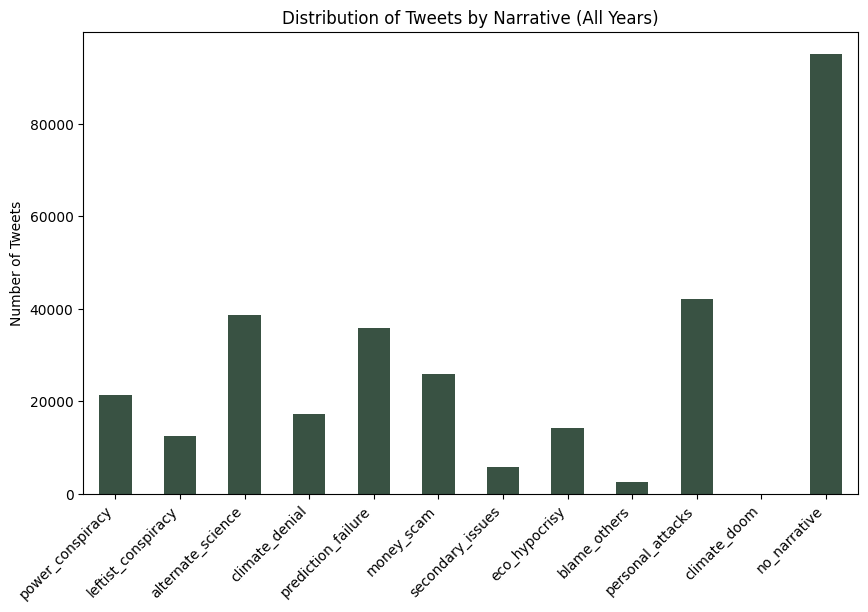

In [ ]:
# Plotting Bar Charts for the overall overview of techniques used

pattern_counts = df[list(patterns.keys()) + ['no_narrative']].sum()

# Plot bar chart
plt.figure(figsize=(10, 6))
pattern_counts.plot(kind='bar', color='#395243')
plt.title('Distribution of Tweets by Narrative (All Years)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.show()

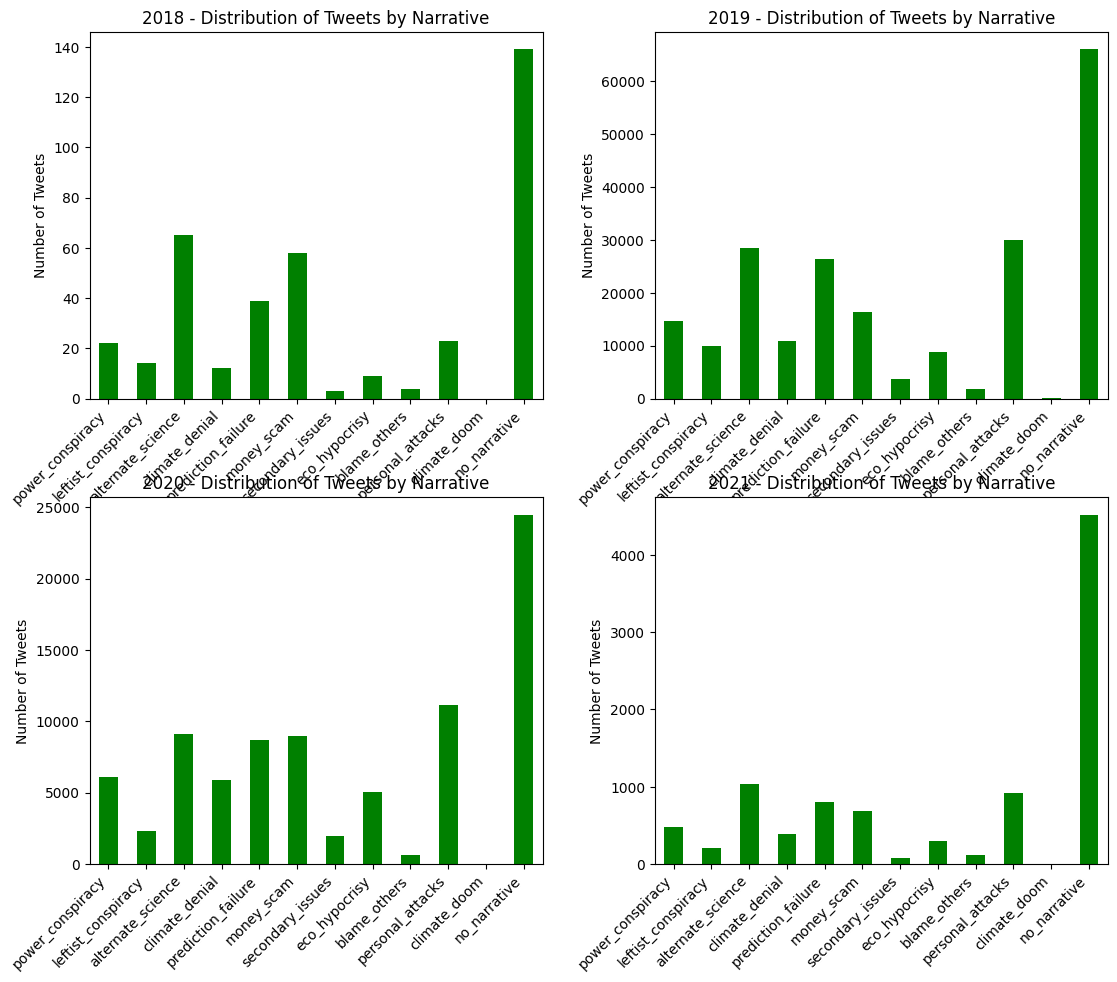

In [ ]:
# Plotting the techniques used per year

# Create a function to plot pattern distribution by year
def plot_by_year(df, year):
    # Filter the dataframe for the specific year
    df_year = df[df['year'] == year]  # Assuming you have a 'year' column in your dataframe
    pattern_counts_year = df_year[list(patterns.keys()) + ['no_narrative']].sum()

    # Plot the counts for the specific year
    plt.figure(figsize=(10, 6))
    pattern_counts_year.plot(kind='bar', color='green')
    plt.title(f'Distribution of Tweets by Narrative for {year}')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# List of years you're interested in
years = [2018, 2019, 2020, 2021]

# Create subplots to show patterns per year in a grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=5.0)

for i, year in enumerate(years):
    ax = axs[i // 2, i % 2]
    df_year = df[df['year'] == year]
    pattern_counts_year = df_year[list(patterns.keys()) + ['no_narrative']].sum()
    pattern_counts_year.plot(kind='bar', ax=ax, color='green')
    ax.set_title(f'{year} - Distribution of Tweets by Narrative')
    ax.set_ylabel('Number of Tweets')
    ax.set_xticklabels(pattern_counts_year.index, rotation=45, ha='right')

plt.show()

In [ ]:
# Print a list of the first 15 tweets in each category, to evaluate if the coding scheme classified tweets well
categories = list(patterns.keys()) + ['no_narrative']

# Loop through each category and print the first 15 tweets
for category in categories:
    print(f"First 15 Tweets for Category: {category}")
    # Filter tweets that belong to the current category
    tweets_in_category = df[df[category] == 1]  # Filter for category tweets with '1'

    # Print the first 15 tweets in the 'text' column
    print(tweets_in_category['cleaned_text'].head(15))
    print("\n" + "-"*50 + "\n")

First 15 Tweets for Category: power_conspiracy
0            chemtrail communist agenda willem felderhof
13     let stupid socialist treasonous like commie ka...
23           chemtrail communist agenda willem felderhof
38         ready internment camp watch speak thank singe
54     climate change normal climate change mankind c...
60     bs way reason west invade destroy country engi...
96     gee want lecture brainwash year old thank educ...
97     gee want lecture brainwash year old thank educ...
124    democrats essentially admit ruse enact marxist...
134    democrats essentially admit ruse enact marxist...
135    democrats essentially admit ruse enact marxist...
136    girl age propaganda get good believe bullsh t ...
142    sad child brainwash leftist learn think kid lo...
151    carbon footprint india spend climate control p...
181        bloomberg publish amount pure propaganda care
Name: cleaned_text, dtype: object

--------------------------------------------------

First 15 Tw

In [ ]:
# Define the columns for denial and delayism
denial_columns = [
    'power_conspiracy', 'money_scam', 'alternate_science',
    'leftist_conspiracy', 'climate_denial', 'prediction_failure'
]

delayism_columns = [
    'personal_attacks', 'secondary_issues', 'eco_hypocrisy', 'blame_others', 'climate_doom', 'money_scam'
]

# Create 'denial' column: 1 if any column in denial_columns has a value of 1
df['denial'] = df[denial_columns].max(axis=1)

# Create 'delayism' column: 1 if any column in delayism_columns has a value of 1
df['delayism'] = df[delayism_columns].max(axis=1)


<Figure size 1200x800 with 0 Axes>

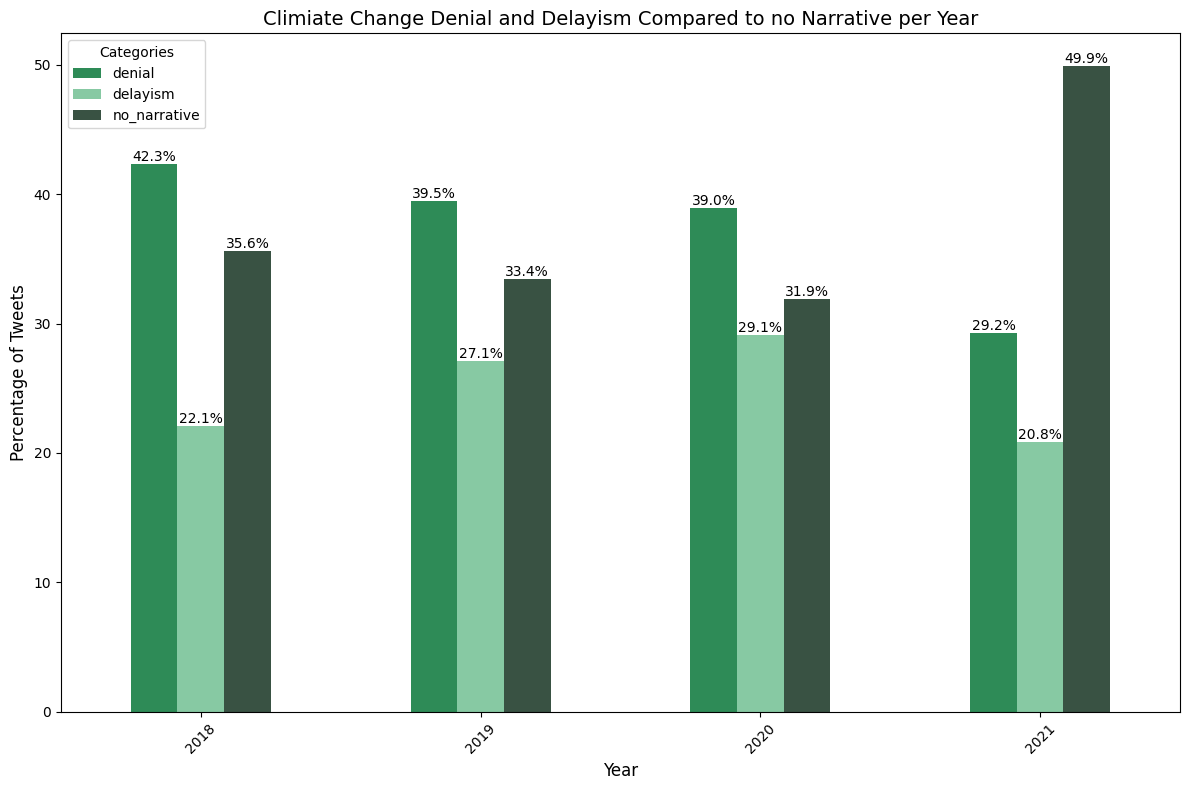

In [ ]:
# Plot climate denial, climate delayism and no narrative per year

# Group by year and sum up the counts for denial, delayism, and no_narrative
summary_by_year = df.groupby('year')[['denial', 'delayism', 'no_narrative']].sum()

# Convert counts to percentages
summary_by_year_percentage = summary_by_year.div(summary_by_year.sum(axis=1), axis=0) * 100

# Plotting the bar chart with percentages
plt.figure(figsize=(12, 8))
ax = summary_by_year_percentage.plot(kind='bar', figsize=(12, 8),
                                     color=['#2E8B57', '#87c9a3', '#395243'])

# Adding percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=10)

# Customizing the plot
plt.title('Climiate Change Denial and Delayism Compared to no Narrative per Year', fontsize=14)
plt.ylabel('Percentage of Tweets', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Categories", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## 3.3 Checking which narrative gets more engagement

In [ ]:
# Creating a table with average retweets for each narrative

# Convert 'retweet_count' to numeric
df['retweet_count'] = pd.to_numeric(df['retweet_count'], errors='coerce')

# Calculate the average retweets for denial and not denial
denial_avg_retweets = df.groupby('denial')['retweet_count'].mean()

# Calculate the average retweets for delayism and no delayism
delayism_avg_retweets = df.groupby('delayism')['retweet_count'].mean()

# Create a new DataFrame for the results
retweet_df = pd.DataFrame({
    'Category': ['Denial', 'Not Denial', 'Delayism', 'No Delayism'],
    'Average Retweets': [
        denial_avg_retweets.get(1, 0),  # Denial (1)
        denial_avg_retweets.get(0, 0),  # Not Denial (0)
        delayism_avg_retweets.get(1, 0),  # Delayism (1)
        delayism_avg_retweets.get(0, 0)   # No Delayism (0)
    ]
})

# Round the Average Retweets column to 2 decimal places
retweet_df['Average Retweets'] = retweet_df['Average Retweets'].round(0)

# Inspect the resulting DataFrame
print(retweet_df)

      Category  Average Retweets
0       Denial             223.0
1   Not Denial             190.0
2     Delayism             282.0
3  No Delayism             168.0


After calculating the average retweets per narrative, I wanted to check if the differences spotted were significant. Initially, I wanted to use a Kruskal-Wallis  test but for some reason I could not get that to work. I started to try some others instead, and the Chi-square test did give me some results, so I ended up using this method.

In [ ]:
# Doing a Chi-square test to test if the differences betweeen denial, delay and no_narrative are significant

# Convert retweet counts into categories
threshold = df['retweet_count'].median()  # Use median retweet count as a cutoff
df['retweet_category'] = np.where(df['retweet_count'] > threshold, 'High', 'Low')

# Create a contingency table
contingency_table = pd.crosstab(df['retweet_category'],
                                df[['denial', 'delayism', 'no_narrative']].idxmax(axis=1))

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print("Chi-Square Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("Significant difference: Retweet behavior differs across categories!")
else:
    print("No significant difference in retweet behavior across categories.")

Chi-Square Statistic: 3167.588537830151
p-value: 0.0
Significant difference: Retweet behavior differs across categories!


#Task 4

Task four analyses the temporal patterns of the Twitter data and their possible alignment with significant events, by looking at top hashtags, terms, and retweeted posts during periods of peak-activity.

**Research question:** How do temporal patterns reflect significant events or shifts in climate change denial discussions?


##4.1 Detecting "spiky" months in tweet counts

To identify months with unusually high tweet activity, we calculated the total number of tweets per month and defined "spiky" months as those where tweet volume exceeded both the preceding and following months. We focused on these spikes as they may correlate with significant events, announcements, or controversies that triggered a surge in discussions.

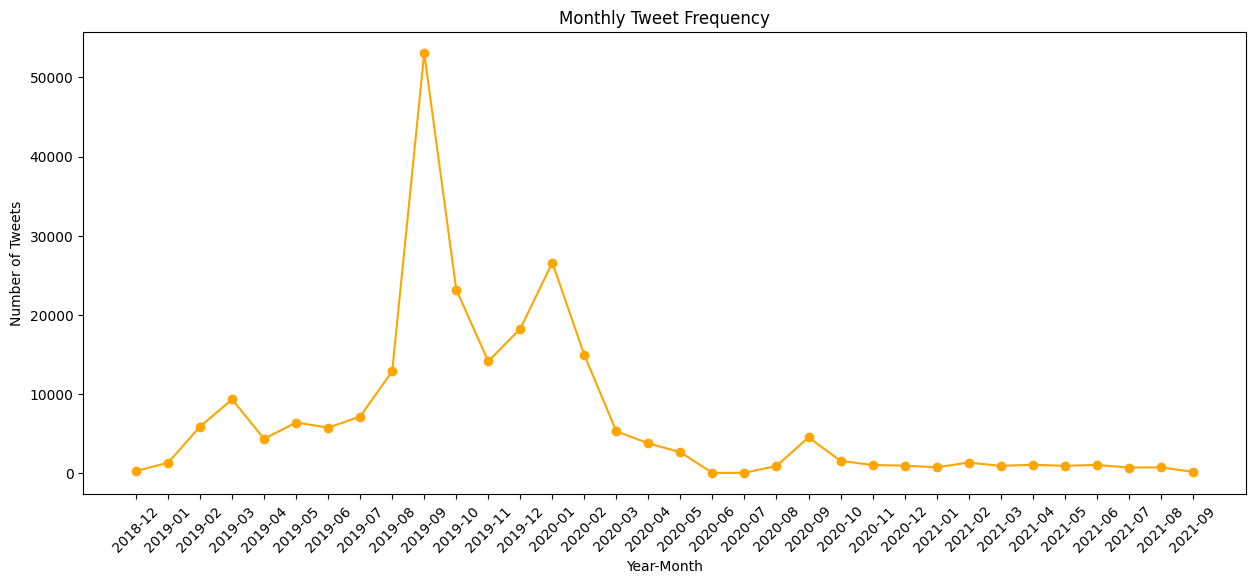

In [ ]:
# Convert dates to year-month format (e.g., '2020-01')
df['month_formatted'] = df['dates_formatted'].dt.to_period('M').astype(str)

# Count the number of posts per month
month_counts = Counter(df['month_formatted'])
month_counts_dict = dict(month_counts)

# Sort months for plotting
sorted_months = sorted(month_counts_dict.items())  # Sort by month
x, y = zip(*sorted_months)  # Unpack months and counts

# Plot the frequency of posts per month
plt.figure(figsize=(15, 6))
plt.plot(x, y, marker='o', color='orange', label='Monthly Frequency')
plt.xticks(rotation=45)
plt.title('Monthly Tweet Frequency')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
def identify_spikes(month_counts_dict):
  """
  Identify months where the number of tweets is higher than both
  the previous month and the following month.
  """
  spike_months = []
  spike_counts = []

  # Iterate through the sorted list, skipping the first and last months
  for i in range(1, len(sorted_months) - 1):
    prev_month, prev_count = sorted_months[i - 1]
    curr_month, curr_count = sorted_months[i]
    next_month, next_count = sorted_months[i + 1]

    # Check if the current month is a spike
    if curr_count > prev_count and curr_count > next_count:
      spike_months.append(curr_month)
      spike_counts.append(curr_count)

  return spike_months, spike_counts

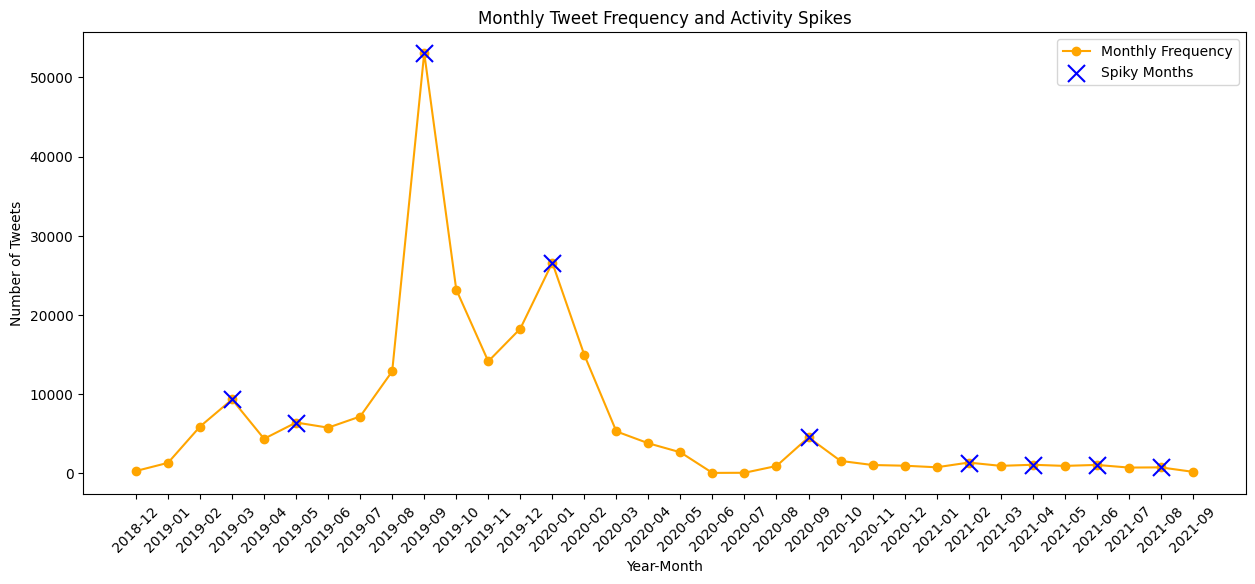

In [ ]:
# Get spike data and indices of spiky months
spike_months, spike_counts = identify_spikes(month_counts_dict)
spike_indices = [x.index(month) for month in spike_months]

# Plot the number of tweets per month, like before
plt.figure(figsize=(15, 6))
plt.plot(x, y, marker='o', color='orange', label='Monthly Frequency')

# Add markers for spiky months
plt.scatter(
  [x[i] for i in spike_indices],  # Spike months
  [y[i] for i in spike_indices],  # Spike counts
  color='blue',
  label='Spiky Months',
  marker='x',
  s=150,      # Adjust marker size
  zorder=2    # Make sure the marker is shown on top of the other plot
)

plt.xticks(rotation=45)
plt.title('Monthly Tweet Frequency and Activity Spikes')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()

In [ ]:
# Display "spiky" months with tweet counts
print(f"Activity spike months:")
for i, spike in enumerate(spike_months):
  print(f"  {spike_months[i]}: {spike_counts[i]} tweets")

Activity spike months:
  2019-03: 9339 tweets
  2019-05: 6431 tweets
  2019-09: 53075 tweets
  2020-01: 26599 tweets
  2020-09: 4554 tweets
  2021-02: 1375 tweets
  2021-04: 1098 tweets
  2021-06: 1080 tweets
  2021-08: 769 tweets


##4.2 Identifying events driving spikes in Twitter activity
To determine if the observed activity spikes could be a reaction to specific events we analyse:
* A. burstiest hashtags,
* B. tweets with highest retweet counts,
* C. dates of highest activity per month,
* D. the burstiest tokens per high-activity date.

###4.2.A: Analyzing **Hashtag Burstiness** in Spiky Months
**Bursty** refers to a pattern where an activity does not happen evenly over time but comes in sudden short spikes. Here, if a hashtag or token is bursty, it means that its use frequency is much higher within a given period than its usual frequency.

In [ ]:
# Remove very rare hashtags that could skew the burstiness calculations

# Iterate over the rows in the dataframe to count hashtags
hashtag_count = defaultdict(int)
for i, hashtags in enumerate(df['filtered_hashtags']):
  for hashtag in hashtags:
    hashtag_count[hashtag] += 1

# Filter hashtags based on a minimal count of 50
filtered_hashtags = [hashtag for hashtag in hashtag_count.keys() if hashtag_count[hashtag] >= 50]
print('All hashtags:', len(hashtag_count.keys()), ', Number of filtered hashtags:', len(filtered_hashtags))

All hashtags: 18655 , Number of filtered hashtags: 556


In [ ]:
def rate_burstiness_normalized(frequencies, dates, daily_totals):
  """
  Calculate the normalized burstiness score for each day by adjusting
  hashtag frequencies relative to total daily tweet volume.
  """
  normalized_frequencies = [
    token_count / daily_totals.get(day, 1)  # Avoid division by zero
    for day, token_count in zip(dates, frequencies)
    ]
  avg = np.mean(normalized_frequencies)  # Average normalized frequency
  burstiness_per_day = [n / avg if avg > 0 else 0 for n in normalized_frequencies]

  return burstiness_per_day

def calculate_burstiness_per_month(df, daily_totals):
  """
  Calculate burstiness scores for each hashtag by aggregating daily hashtag
  counts and normalizing their frequency.
  """
  hashtag_burstiness = defaultdict(list)

  # Group by date and calculate daily hashtag counts
  daily_hashtag_counts = df.groupby('dates_formatted')['filtered_hashtags'].sum()
  for day, hashtags in daily_hashtag_counts.items():
    hashtag_counts = Counter(hashtags)
    for hashtag, count in hashtag_counts.items():
      hashtag_burstiness[hashtag].append((day, count))

  # Calculate burstiness scores for each hashtag
  hashtag_burstiness_scores = {}
  for hashtag, day_counts in hashtag_burstiness.items():
    dates, counts = zip(*day_counts)
    burstiness_per_day = rate_burstiness_normalized(counts, dates, daily_totals)
    hashtag_burstiness_scores[hashtag] = dict(zip(dates, burstiness_per_day))

  return hashtag_burstiness_scores

def aggregate_burstiness_to_monthly(hashtag_burstiness_scores):
  """
  Aggregate daily burstiness scores to monthly values by summing hashtag
  burstiness across all days in a given month.
  """
  monthly_burstiness = defaultdict(lambda: defaultdict(float))
  for hashtag, daily_burstiness in hashtag_burstiness_scores.items():
    for day, score in daily_burstiness.items():
      month = day.strftime('%Y-%m')  # Use strftime to extract year-month
      monthly_burstiness[month][hashtag] += score

  return monthly_burstiness

In [ ]:
date_counts = Counter(df['dates_formatted'])
date_counts_dict = dict(date_counts)

# Calculate bursty hashtags
daily_totals = date_counts_dict
hashtag_burstiness_scores = calculate_burstiness_per_month(df, daily_totals)
monthly_burstiness = aggregate_burstiness_to_monthly(hashtag_burstiness_scores)

# Display bursty hashtags for spiky months
for month in spike_months:
  if month in monthly_burstiness:
    print(f"\nTop bursty hashtags for {month}:")
    bursty_hashtags = sorted(monthly_burstiness[month].items(), key=lambda x: x[1], reverse=True)
    for hashtag, score in bursty_hashtags[:10]:
      print(f"#{hashtag}: {score:.2f}")


Top bursty hashtags for 2019-03:
#greennewdeal: 75.35
#wethepeople: 52.03
#facts: 45.90
#socialist: 34.85
#maga: 33.94
#socialismkills: 33.44
#aoc: 30.04
#the50billiondollarman: 28.82
#qla: 28.82
#borderwall: 26.62

Top bursty hashtags for 2019-05:
#borderwall: 27.28
#the50billiondollarman: 25.06
#qla: 25.06
#democrat: 22.99
#climatechangethefacts: 22.95
#carbontaxscam: 22.25
#cabal: 21.94
#wethepeople: 21.87
#pjnet: 20.83
#maga: 20.50

Top bursty hashtags for 2019-09:
#kag: 54.96
#climatestrike: 48.21
#trump2020landside: 32.34
#climatechange: 31.17
#kag2020: 28.84
#greatawakeningworldwide: 24.02
#womenfortrump: 22.86
#aoc: 21.75
#gretathunberg: 21.45
#democraticdebate: 20.06

Top bursty hashtags for 2020-01:
#australia: 40.50
#wakeupamerica: 39.78
#climatechange: 28.45
#climateemergency: 28.20
#climateemergencyhoax: 28.17
#climatedebate: 26.35
#climateemegency: 26.10
#climatechangeisreal: 25.46
#extinctionrebellion: 23.72
#australiafires: 22.99

Top bursty hashtags for 2020-09:
#nwo:

###4.2.B: Finding **Most Retweeted Posts** per Spiky Month
What messages were widely shared?

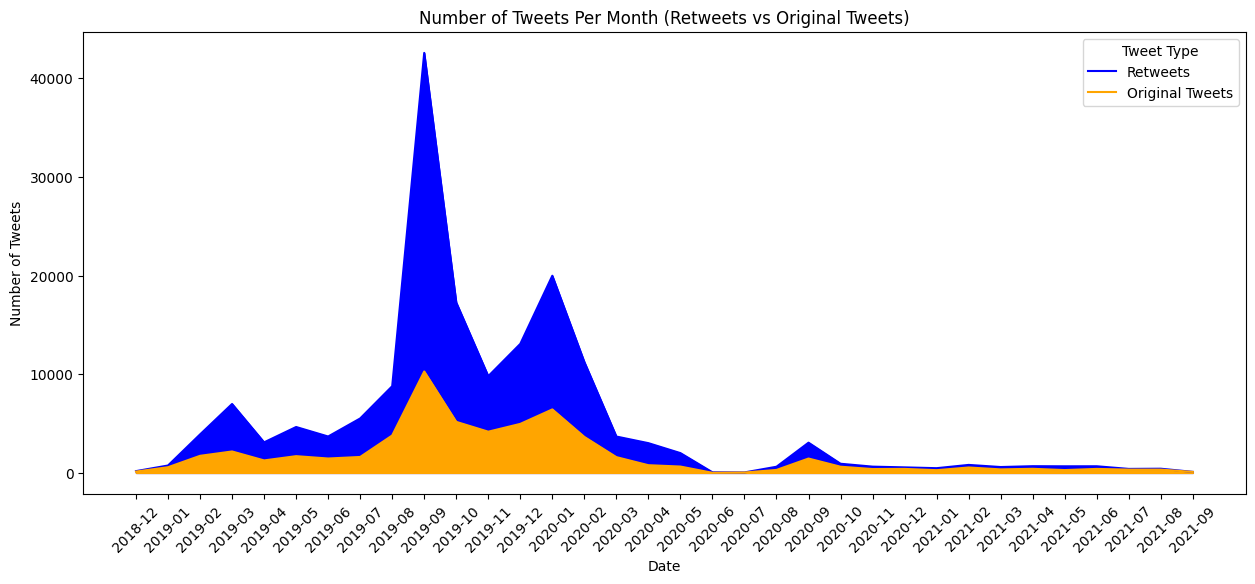

In [ ]:
# Plot tweets per month vs retweets per month

grouped_counts = df.groupby(['month_formatted', 'is_retweet']).size().unstack(fill_value=0)
grouped_counts = grouped_counts.sort_index()

# Plot the counts for both TRUE and FALSE in 'is_retweet'
plt.figure(figsize=(15, 6))
plt.plot(grouped_counts.index, grouped_counts['TRUE'], label='Retweets', color='blue')
plt.plot(grouped_counts.index, grouped_counts['FALSE'], label='Original Tweets', color='orange')

# Fill the area under the curves
plt.fill_between(grouped_counts.index, grouped_counts['TRUE'], color='blue')
plt.fill_between(grouped_counts.index, grouped_counts['FALSE'], color='orange')

plt.xticks(rotation=45)
plt.legend(title="Tweet Type")
plt.title('Number of Tweets Per Month (Retweets vs Original Tweets)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
# Count how many times a posts was duplicated in a day
# (more reliable than retweet counts)

for month in spike_months:
  # Filter posts for the current spiky month
  month_posts = df.loc[df['month_formatted'] == month, 'text']

  # Count occurrences of each post
  post_counts = month_posts.value_counts().reset_index()
  post_counts.columns = ['text', 'count']  # Rename columns for clarity

  # Select top 5 most duplicated posts
  top_5_posts = post_counts.head(5)

  # Print results for this month
  print(f"\nTop 5 retweeted posts for {month}:")
  for _, row in top_5_posts.iterrows():
    clean_text = " ".join(row['text'].split())
    print(f"  Retweeted {row['count']} times | Post: {clean_text}")


Top 5 retweeted posts for 2019-03:
  Retweeted 657 times | Post: Clint Eastwood on @AOC's #GreenNewDeal #ClimateChangeHoax https://t.co/ETaZnjkJRx
  Retweeted 652 times | Post: Nopeâ€”We donâ€™t take kindly to lecturing on future generations by someone wanting to kill future generations Pelosi: We have a â€˜moral obligationâ€™ to future generations on climate change, but not against killing them in the womb #ClimateChangeHoax https://t.co/N4v2tLMgFP
  Retweeted 424 times | Post: While #WeThePeople know these #facts re: #ClimateChangeHoax this explains from CLIMATE SCIENTIST how @TheDemocrats mind control with â€˜97% climate scientists agreeâ€™ - loved it thanks for sharing Lori! @CNN did appear to be stuttering! #Hahaha this was hoax for money all along! https://t.co/tqZKyX2g7H
  Retweeted 411 times | Post: Swarms of youngsters today marched cheerily to protest something, all the while spouting breathtakingly incoherent tropes and slogans with nary a clue as to anthropogenic causation

###4.2.C: Finding **Most Active Days** of the Spiky Months
This might help narrow down when an event was taking place

In [ ]:
date_counts = Counter(df['dates_formatted'])
date_counts_dict = dict(date_counts)

top_month_days = {}

# Print the top n days for each spiky month
n = 5
for month in spike_months:
  print(f"\nTop {n} days in {month}:")

  # Filter date counts for the current month
  month_days = {date: count for date, count in date_counts_dict.items() if str(date)[:7] == month}

  # Get the top n days with the most tweets in that month
  top_n_days = sorted(month_days.items(), key=lambda x: x[1], reverse=True)[:n]

  # Save the top n days in a dictionary for future use
  top_month_days[month] = [str(date)[:10] for date, _ in top_n_days]  # Store only the date

  # Print results
  for date, count in top_n_days:
    print(f"  {date.date()}: {count} tweets")


Top 5 days in 2019-03:
  2019-03-27: 861 tweets
  2019-03-13: 837 tweets
  2019-03-16: 749 tweets
  2019-03-28: 736 tweets
  2019-03-15: 593 tweets

Top 5 days in 2019-05:
  2019-05-05: 941 tweets
  2019-05-04: 588 tweets
  2019-05-14: 431 tweets
  2019-05-18: 311 tweets
  2019-05-25: 301 tweets

Top 5 days in 2019-09:
  2019-09-24: 9510 tweets
  2019-09-23: 5785 tweets
  2019-09-22: 4456 tweets
  2019-09-25: 4319 tweets
  2019-09-06: 4154 tweets

Top 5 days in 2020-01:
  2020-01-13: 1606 tweets
  2020-01-07: 1569 tweets
  2020-01-06: 1468 tweets
  2020-01-11: 1362 tweets
  2020-01-09: 1359 tweets

Top 5 days in 2020-09:
  2020-09-15: 974 tweets
  2020-09-16: 564 tweets
  2020-09-17: 344 tweets
  2020-09-12: 276 tweets
  2020-09-13: 274 tweets

Top 5 days in 2021-02:
  2021-02-16: 153 tweets
  2021-02-07: 112 tweets
  2021-02-17: 100 tweets
  2021-02-15: 99 tweets
  2021-02-20: 81 tweets

Top 5 days in 2021-04:
  2021-04-23: 111 tweets
  2021-04-27: 76 tweets
  2021-04-22: 70 tweets
 

###4.2.D: Analyzing **Token Burstiness** in Most Active Days of the Spiky Months

In [ ]:
# Count the frequency of each token in the dataset
token_count = defaultdict(int)
for i,tokens in enumerate(df['tokenized']):
  for token in tokens:
    token_count[token] += 1

# Filter tokens based on a minimal count of 50
filtered_tokens = [token for token in token_count.keys() if token_count[token] >= 50]
print('All tokens:',len(token_count.keys()),', Number of filtered tokens:',len(filtered_tokens))

All tokens: 23287 , Number of filtered tokens: 3898


In [ ]:
# Extract the number of days in the dataset
earliest = df['dates_formatted'].min()
latest = df['dates_formatted'].max()
difference = latest-earliest
period = difference.days
date_range = [str(earliest + timedelta(days=x)) for x in range(period+1)]

# Initialize the day-by-day frequency of all filtered tokens as a list of zero's within the date range
token_date_counts = {}
for token in filtered_tokens:
  token_date_counts[token] = [0]*len(date_range)

dates = df['dates_formatted']

for i,tokens in enumerate(df['tokenized']):
  if i in range(0,250000,50000):
    print('line',i,'of',len(df['tokenized']))
  d = str(dates[i]) # Get the date as a string
  index = date_range.index(d)  # Get the index of the date
  # For each filtered token in the post, update its frequency list in token_date_counts
  for token in tokens:
    if token in filtered_tokens:
      token_date_counts[token][index] = 1000

line 0 of 232896
line 50000 of 232896
line 100000 of 232896
line 150000 of 232896
line 200000 of 232896


In [ ]:
# Score the day-by-day burstiness per token, normalized by daily total posts
burstiness_by_token = {}
for token, token_counts in token_date_counts.items():
  dates = list(daily_totals.keys())  # Ensure this aligns with token_counts order
  burstiness_per_day = rate_burstiness_normalized(token_counts, dates, daily_totals)
  burstiness_by_token[token] = burstiness_per_day

def return_burstiness_by_date(burstiness_per_day):
  """
  Identify the most bursty words for each day by filtering those
  with a burstiness score greater than 10.
  """
  date_burstiness = []
  for i,b in enumerate(burstiness_per_day):
    if b > 10:
      date_burstiness.append([dates[i],b])
  return date_burstiness

date_bursty_tokens = defaultdict(list)
for token in filtered_tokens:
  date_burstiness = return_burstiness_by_date(burstiness_by_token[token])
  for line in date_burstiness:
    date_bursty_tokens[line[0]].append([token,line[1]])

In [ ]:
# Get the burstiets words for most active days in spiky months
for month, days in top_month_days.items():
  print(f"\nTop bursty tokens for days in {month}:")
  for day in days:
    for d in sorted(date_bursty_tokens):
      if str(d)[:10] == str(day)[:10]:
        bursty_tokens = sorted(date_bursty_tokens[d], key=lambda k: k[1], reverse=True)
        # Print the date and the top 3 bursty tokens
        print(f"  {str(d)[:10]}: " + ", ".join([x[0] for x in bursty_tokens[:10]]))


Top bursty tokens for days in 2019-03:
  2019-03-27: kiddin, uncle, gillibrand, coward, incapable, outstanding, accompany, ridd, representation, ummm
  2019-03-13: daylight, weep, differ, click, isis, farting, dinner, urban, blessing, profiteer
  2019-03-16: cheerily, breathtakingly, swarm, causation, midterm, trope, helpful, chinastein, allegedly, proxy
  2019-03-28: kiddin, obey, pun, beta, isis, asteroid, rio, offender, neighborhood, fece
  2019-03-15: cheerily, breathtakingly, swarm, collage, causation, trope, chinastein, allegedly, padded, classroom

Top bursty tokens for days in 2019-05:
  2019-05-05: coffin, rarely, harmful, muppet, parade
  2019-05-04: outraged, obnoxious, kzn, durban, dishonesty, despise, wannabe, hamburger, urban, fearful
  2019-05-14: faker, mobilize, lobbying, umm, darling, recall, startling, intellect, com, holiday
  2019-05-18: temper, trendy, puke, piper, cont, wether, successfully, consumer, frighten, boomer
  2019-05-25: venomous, anglican, swift, tum